# Constant-Q transform spectral envelope coefficients (CQT-SEC)

## 01. Assumption and observations

### Assumption

A log-spectrum, such as the CQT-spectrum, can be represented as the convolution of a pitch-invariant log-spectal envelope component (~ timbre) and a envelope-normalized pitch component.

`X = E * P`

### Observation 1

A pitch change in the audio translates to a linear shift in the log-spectrum. 

This means that the same musical object at different pitches should have a similar envelope component but a shifted pitch component; while two different musical objects at the same pitch should have different envelope components but a similar pitch component.

- `X = E * P`

- `X2 = E2 * P2`

`=> E ~ E2`

#### Example 1: Two sinusoids at different pitches and their CQT-spectrogram

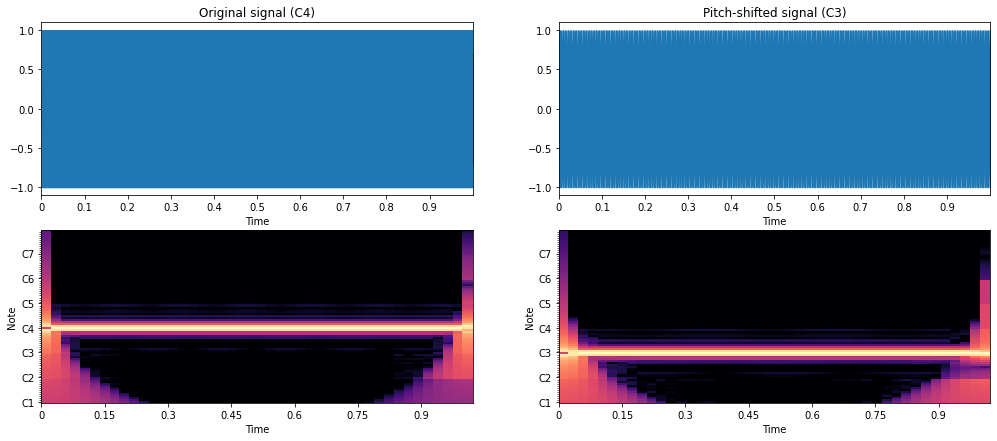

In [10]:
%matplotlib inline

import numpy as np
import librosa
import librosa.display
import matplotlib.pyplot as plt

# Define two sinusoids, with one twice lower in frequency than the other one
sampling_frequency = 44100                                     # In Hz
time_duration = 1                                              # In seconds
time_array = np.arange(0, time_duration, 1/sampling_frequency) # In seconds
frequency_value1 = 261.63                                      # In Hz (= C4)
frequency_value2 = frequency_value1/2                          # In Hz (= C3)
audio_signal1 = np.sin(time_array*2*np.pi*frequency_value1)
audio_signal2 = np.sin(time_array*2*np.pi*frequency_value2)

# Comptute the CQT spectrogram for the signals
step_length = int(pow(2, int(np.ceil(np.log2(0.04*sampling_frequency))))/2)
audio_spectrogram1 = np.abs(librosa.cqt(audio_signal1, sr=sampling_frequency, hop_length=step_length))
audio_spectrogram2 = np.abs(librosa.cqt(audio_signal2, sr=sampling_frequency, hop_length=step_length))

# Display their waveform in seconds and their power CQT spectrogram in seconds and notes
plt.figure(figsize=(17, 7))
plt.subplot(2, 2, 1)
librosa.display.waveplot(audio_signal1, sr=sampling_frequency)
plt.title('Original signal (C4)')
plt.subplot(2, 2, 2)
librosa.display.waveplot(audio_signal2, sr=sampling_frequency)
plt.title('Pitch-shifted signal (C3)')
plt.subplot(2, 2, 3)
librosa.display.specshow(librosa.amplitude_to_db(audio_spectrogram1, ref=np.max), sr=sampling_frequency, \
                         hop_length=step_length, x_axis='time', y_axis='cqt_note')
plt.subplot(2, 2, 4)
librosa.display.specshow(librosa.amplitude_to_db(audio_spectrogram2, ref=np.max), sr=sampling_frequency, \
                         hop_length=step_length, x_axis='time', y_axis='cqt_note')
plt.show()

#### Example 2: Two notes at different pitches and their CQT-spectrogram

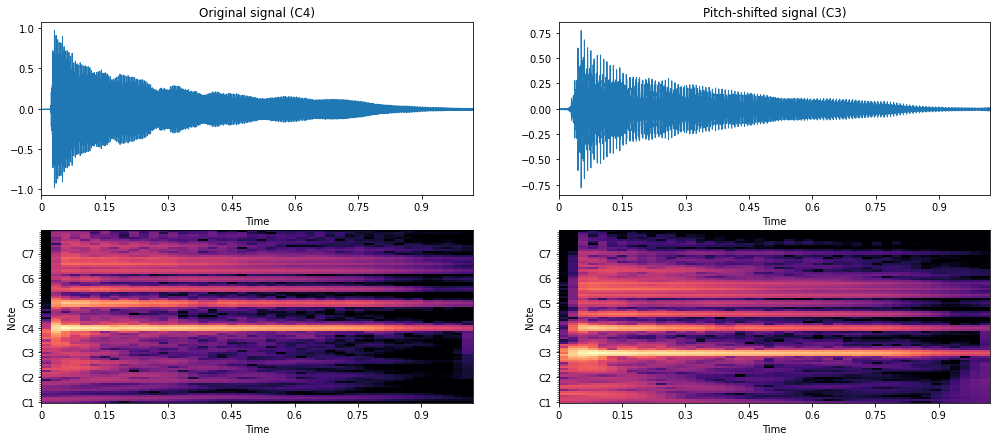

In [9]:
import numpy as np
import librosa
import librosa.display
import matplotlib.pyplot as plt

# Load an audio file with its sampling frequency, and keep only one note in its left channel (= C4)
file_path = r'94812__digifishmusic__c4-major-scale-piano.wav'
audio_signal, sampling_frequency = librosa.load(file_path, sr=None, mono=False)
audio_signal1 = audio_signal[0, 24000:69000]

# Shift down the note by a whole octave (2x lower in frequency) (= C3)
audio_signal2 = librosa.effects.pitch_shift(audio_signal1, sampling_frequency, n_steps=-12)

# Comptute the CQT spectrogram for the signals
step_length = int(pow(2, int(np.ceil(np.log2(0.04*sampling_frequency))))/2)
audio_spectrogram1 = np.abs(librosa.cqt(audio_signal1, sr=sampling_frequency, hop_length=step_length))
audio_spectrogram2 = np.abs(librosa.cqt(audio_signal2, sr=sampling_frequency, hop_length=step_length))

# Display their waveform in seconds and their power CQT spectrogram in seconds and notes
plt.figure(figsize=(17, 7))
plt.subplot(2, 2, 1)
librosa.display.waveplot(audio_signal1, sr=sampling_frequency)
plt.title('Original signal (C4)')
plt.subplot(2, 2, 2)
librosa.display.waveplot(audio_signal2, sr=sampling_frequency)
plt.title('Pitch-shifted signal (C3)')
plt.subplot(2, 2, 3)
librosa.display.specshow(librosa.amplitude_to_db(audio_spectrogram1, ref=np.max), sr=sampling_frequency, \
                         hop_length=step_length, x_axis='time', y_axis='cqt_note')
plt.subplot(2, 2, 4)
librosa.display.specshow(librosa.amplitude_to_db(audio_spectrogram2, ref=np.max), sr=sampling_frequency, \
                         hop_length=step_length, x_axis='time', y_axis='cqt_note')
plt.show()

### Observation 2

The Fourier transform (FT) of a convolution of two functions is equal to the point-wise product of their FTs (convolution theorem).

- `F(X) = F(E) x F(P)`
- `F(X2) = F(E2) x F(P2)`

`=> F(E) ~ F(E2)`

#### Example: Direct vs indirect convolution

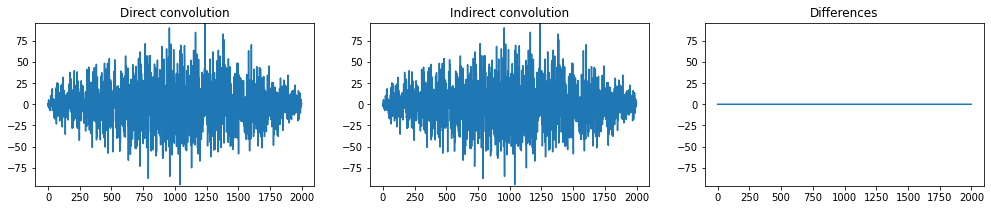

In [11]:
import numpy as np
import matplotlib.pyplot as plt

# Define two arrays
number_elements = 1000
data_array1 = np.random.normal(size=number_elements)
data_array2 = np.random.normal(size=number_elements)

# Compute the direct convolution between them
data_convolution = np.convolve(data_array1, data_array2)

# Compute the convolution using the convolution theorem
ft_array1 = np.fft.fft(data_array1, 2*number_elements-1)
ft_array2 = np.fft.fft(data_array2, 2*number_elements-1)
data_convolution2 = np.real(np.fft.ifft(ft_array1*ft_array2))

# Display the convolutions and their differences
maximum_value = max(abs(data_convolution))
plt.figure(figsize=(17, 3))
plt.subplot(1, 3, 1)
plt.plot(data_convolution), plt.ylim(-maximum_value, maximum_value), plt.title('Direct convolution')
plt.subplot(1, 3, 2)
plt.plot(data_convolution2), plt.ylim(-maximum_value, maximum_value), plt.title('Indirect convolution')
plt.subplot(1, 3, 3)
plt.plot(data_convolution-data_convolution2), plt.ylim(-maximum_value, maximum_value), plt.title('Differences')
plt.show()

### Observation 3

The magnitude FT is shift-invariant.

- `F(X) = abs(F(X)) x exp(j*angle(F(X)))`

- `F(X2) = abs(F(X2)) x exp(j*angle(F(X2)))`

`=> abs(F(X)) ~ abs(F(X2))`

Conclusion:

`=> F(E) ~ abs(F(X)) => E ~ F-1(abs(F(X))) and P ~ F-1(exp(j*angle(F(X))))`

#### Example 1: An array and a shifted version of it, and their magnitude FT

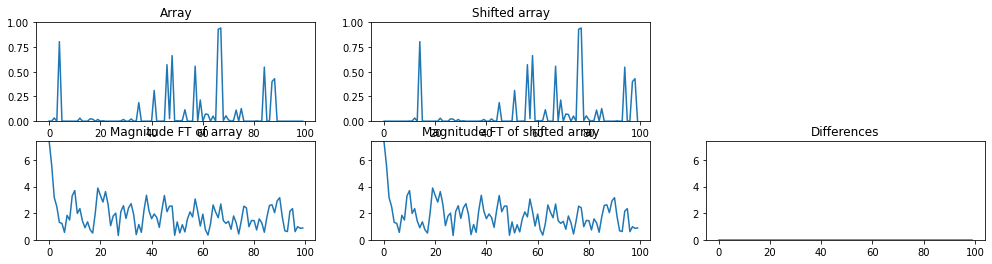

In [12]:
import numpy as np
import matplotlib.pyplot as plt

# Define a non-negative array and a shifted version of it
number_elements = 100
delay_size = 10
data_array1 = np.concatenate((np.power(np.random.rand(number_elements-delay_size), 10), np.zeros(delay_size)))
data_array2 = np.concatenate((np.zeros(delay_size), data_array1[0:number_elements-delay_size]))

# Compute the magnitude FT of the arrays
absft_array1 = abs(np.fft.fft(data_array1, 2*number_elements-1))[0:number_elements]
absft_array2 = abs(np.fft.fft(data_array2, 2*number_elements-1))[0:number_elements]

# Display the arrays and magnitude FTs
maximum_value = max(np.max(absft_array1), np.max(absft_array2))
plt.figure(figsize=(17, 4))
plt.subplot(2, 3, 1), plt.plot(data_array1), plt.ylim(0, 1), plt.title('Array')
plt.subplot(2, 3, 2), plt.plot(data_array2), plt.ylim(0, 1), plt.title('Shifted array')
plt.subplot(2, 3, 4), plt.plot(absft_array1), plt.ylim(0, maximum_value), plt.title('Magnitude FT of array')
plt.subplot(2, 3, 5), plt.plot(absft_array2), plt.ylim(0, maximum_value), plt.title('Magnitude FT of shifted array')
plt.subplot(2, 3, 6), plt.plot(abs(absft_array1-absft_array2)), plt.ylim(0, maximum_value), plt.title('Differences')
plt.show()

#### Example 2: A CQT spectrum and a pitch-shifted version of it, and their magnitude FT

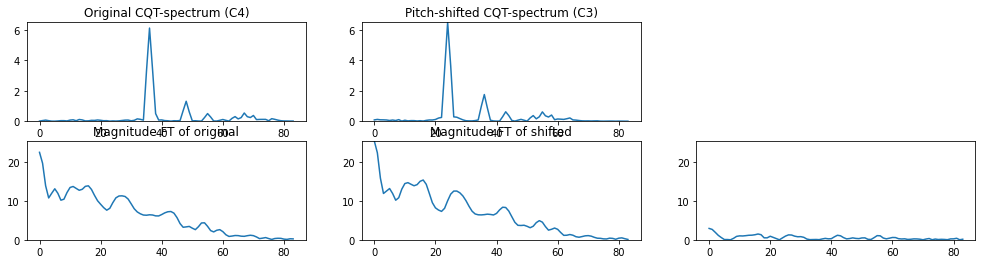

In [31]:
import numpy as np
import librosa
import matplotlib.pyplot as plt

# Load an audio file with its sampling frequency, and keep only one note in its left channel (= C4)
file_path = r'94812__digifishmusic__c4-major-scale-piano.wav'
audio_signal, sampling_frequency = librosa.load(file_path, sr=None, mono=False)
audio_signal1 = audio_signal[0, 24000:69000]

# Shift down the note by a whole octave (2x lower in frequency) (= C3)
audio_signal2 = librosa.effects.pitch_shift(audio_signal1, sampling_frequency, n_steps=-12)

# Comptute the CQT-spectrogram for the signals
step_length = int(pow(2, int(np.ceil(np.log2(0.04*sampling_frequency))))/2)
audio_spectrogram1 = np.abs(librosa.cqt(audio_signal1, sr=sampling_frequency, hop_length=step_length))
audio_spectrogram2 = np.abs(librosa.cqt(audio_signal2, sr=sampling_frequency, hop_length=step_length))
number_frequencies = np.shape(audio_spectrogram1)[0]

# Compute the magnitude FT of the CQT-spectrograms
absft_spectrogram1 = abs(np.fft.fft(audio_spectrogram1, 2*number_frequencies-1, axis=0))[0:number_frequencies, :]
absft_spectrogram2 = abs(np.fft.fft(audio_spectrogram2, 2*number_frequencies-1, axis=0))[0:number_frequencies, :]

# Display their waveform in seconds and their power CQT-spectrogram in seconds and notes
i = 10
audio_maximum = max(np.max(abs(audio_spectrogram1[:, i])), np.max(abs(audio_spectrogram2[:, i])))
absft_maximum = max(np.max(abs(absft_spectrogram1[:, i])), np.max(abs(absft_spectrogram2[:, i])))
plt.figure(figsize=(17, 4))
plt.subplot(2, 3, 1), plt.plot(audio_spectrogram1[:, i]), plt.ylim(0, audio_maximum), plt.title('Original CQT-spectrum (C4)')
plt.subplot(2, 3, 2), plt.plot(audio_spectrogram2[:, i]), plt.ylim(0, audio_maximum), plt.title('Pitch-shifted CQT-spectrum (C3)')
plt.subplot(2, 3, 4), plt.plot(absft_spectrogram1[:, i]), plt.ylim(0, absft_maximum), plt.title('Magnitude FT of original')
plt.subplot(2, 3, 5), plt.plot(absft_spectrogram2[:, i]), plt.ylim(0, absft_maximum), plt.title('Magnitude FT of shifted')
plt.subplot(2, 3, 6), plt.plot(abs(absft_spectrogram1[:, i]-absft_spectrogram2[:, i])), plt.ylim(0, absft_maximum)
plt.show()

## 02. Compare librosa's and zaf's CQT-spectrogram and MFCC

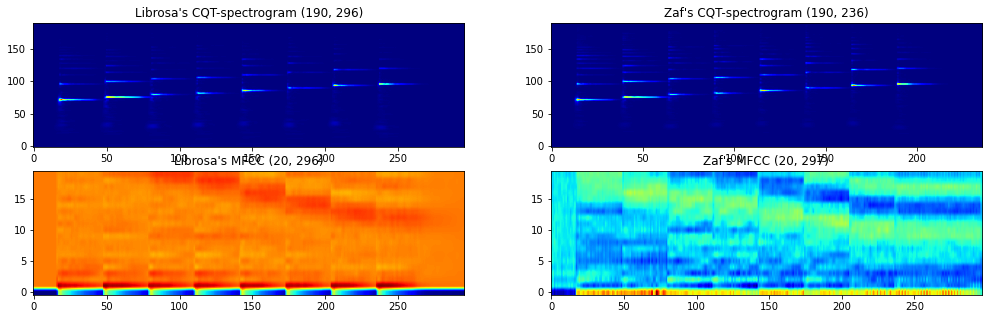

In [33]:
import numpy as np
import librosa
import zaf
import scipy.signal
import matplotlib.pyplot as plt

# Load an audio file in mono
file_path = r'94812__digifishmusic__c4-major-scale-piano.wav'
sampling_frequency = 16000
audio_signal, sampling_frequency = librosa.load(file_path, sr=sampling_frequency, mono=True)

# Define some parameters
window_length = pow(2, int(np.ceil(np.log2(0.04 * sampling_frequency))))
step_length = int(window_length/2)
window_function = scipy.signal.hamming(window_length, sym=False)
minimum_frequency = 32.70
maximum_frequency = sampling_frequency/2
octave_resolution = 24
time_resolution = 25
number_mels = 40
number_coefficients = 20

# Compute the CQT-spectrogram using librosa and zaf
number_frequencies = round(octave_resolution * np.log2(maximum_frequency / minimum_frequency))
cqt_spectrogram = np.abs(librosa.cqt(audio_signal, sr=sampling_frequency, hop_length=step_length, \
                                     fmin=minimum_frequency, n_bins=number_frequencies, bins_per_octave=octave_resolution))
cqt_kernel = zaf.cqtkernel(sampling_frequency, octave_resolution, minimum_frequency, maximum_frequency)
cqt_spectrogram2 = zaf.cqtspectrogram(audio_signal, sampling_frequency, time_resolution, cqt_kernel)

# Compute the MFCCs using librosa and zaf
audio_mfcc = librosa.feature.mfcc(y=audio_signal, sr=sampling_frequency, n_mfcc=number_coefficients, \
                                  hop_length=step_length)
mel_filterbank = zaf.melfilterbank(sampling_frequency, window_length, number_mels)
audio_mfcc2 = zaf.mfcc(audio_signal, window_function, step_length, mel_filterbank, number_coefficients)

# Display the CQT-spectrograms and the MFCCs
plt.figure(figsize=(17, 5))
plt.subplot(2, 2, 1)
plt.imshow(cqt_spectrogram, aspect='auto', cmap='jet', origin='lower')
plt.title(f"Librosa's CQT-spectrogram {np.shape(cqt_spectrogram)}")
plt.subplot(2, 2, 2)
plt.imshow(cqt_spectrogram2, aspect='auto', cmap='jet', origin='lower')
plt.title(f"Zaf's CQT spectrogram {np.shape(cqt_spectrogram2)}")
plt.subplot(2, 2, 3)
plt.imshow(audio_mfcc, aspect='auto', cmap='jet', origin='lower')
plt.title(f"Librosa's MFCC {np.shape(audio_mfcc)}")
plt.subplot(2, 2, 4)
plt.imshow(audio_mfcc2, aspect='auto', cmap='jet', origin='lower')
plt.title(f"Zaf's MFCC {np.shape(audio_mfcc2)}")
plt.show()

## 03. Test decomposing the CQT-spectrogram into a CQT-envelope and a CQT-pitch

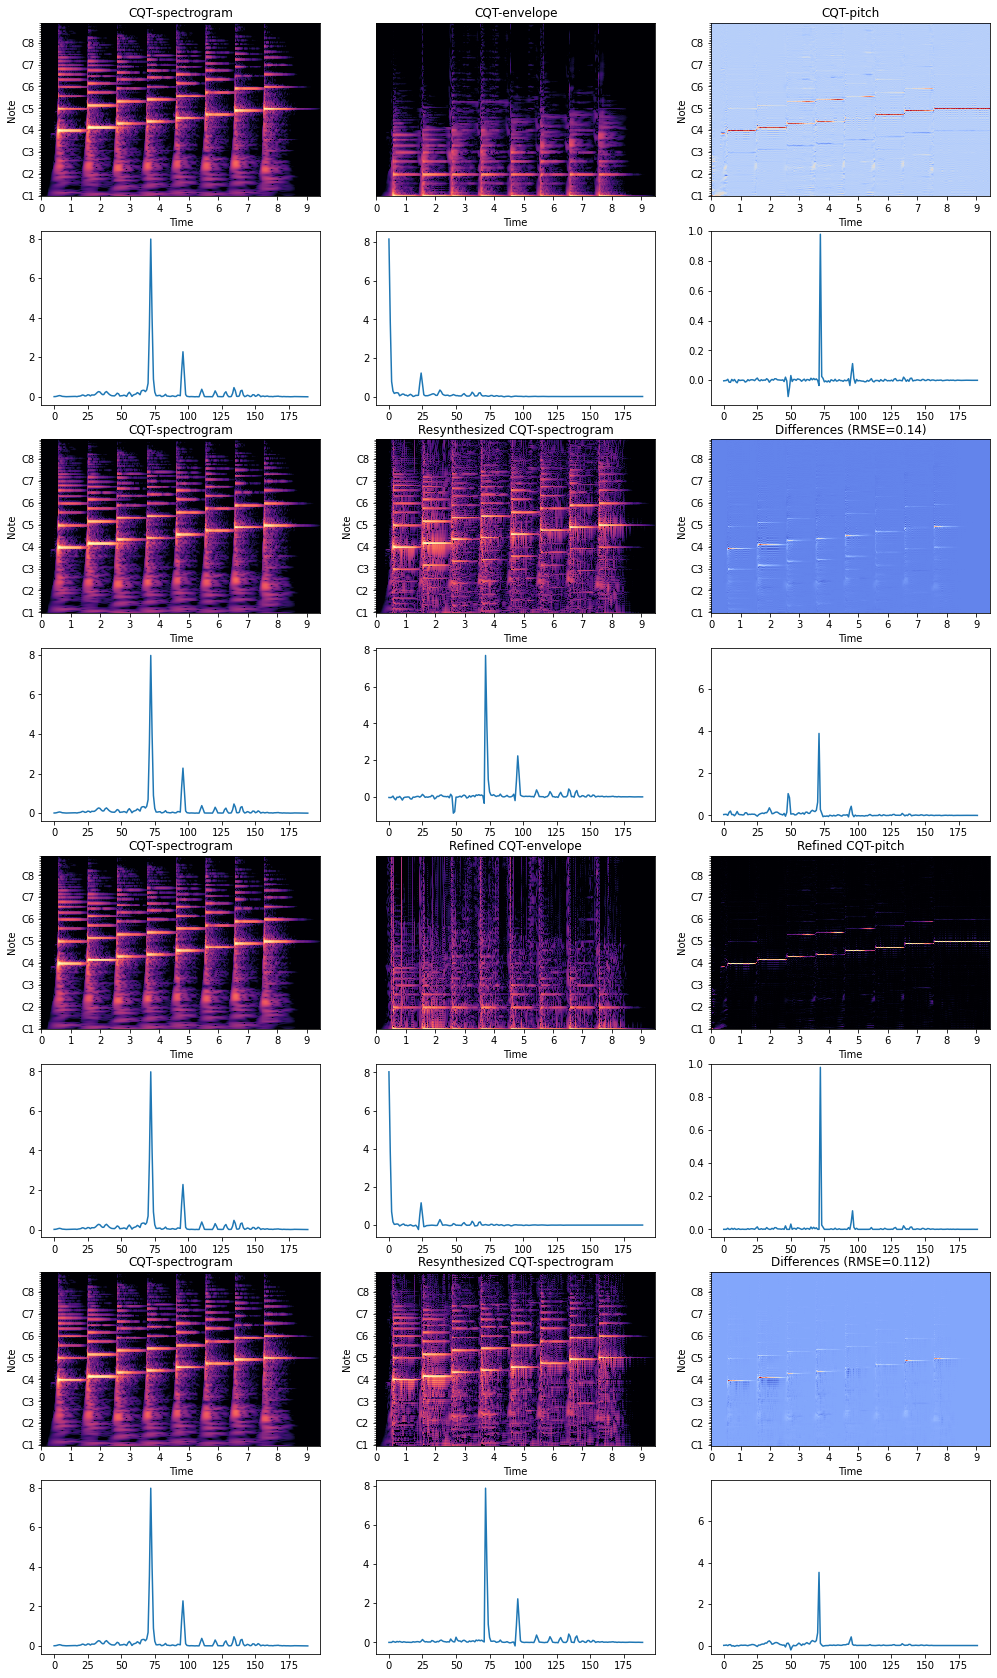

In [43]:
import numpy as np
import librosa
import librosa.display
import matplotlib.pyplot as plt
import warnings
import matplotlib.cbook
warnings.filterwarnings('ignore',category=matplotlib.cbook.mplDeprecation)

# Load an audio file with its sampling frequency, and keep only its left channel
file_path = r'94812__digifishmusic__c4-major-scale-piano.wav'
# file_path = r'557469__oleviolin__d-scale-violin.wav'
sampling_frequency = 16000
audio_signal, _ = librosa.load(file_path, sr=sampling_frequency, mono=True)

# Comptute the CQT-spectrogram of the signal
step_length = int(pow(2, int(np.ceil(np.log2(0.04*sampling_frequency))))/2)
minimum_frequency = 32.70
maximum_frequency = sampling_frequency/2
octave_resolution = 24
number_frequencies = round(octave_resolution * np.log2(maximum_frequency / minimum_frequency))
audio_cqt = librosa.cqt(audio_signal, sr=sampling_frequency, hop_length=step_length, fmin=minimum_frequency, \
                        n_bins=number_frequencies, bins_per_octave=octave_resolution)
cqt_spectrogram = np.abs(audio_cqt)
number_times = np.shape(cqt_spectrogram)[1]

# Derive the CQT-envelope and the CQT-pitch
ftcqt_spectrogram = np.fft.fft(cqt_spectrogram, 2*number_frequencies-1, axis=0)
absftcqt_spectrogram = abs(ftcqt_spectrogram)
cqt_envelope = np.real(np.fft.ifft(absftcqt_spectrogram, axis=0)[0:number_frequencies, :])
cqt_pitch = np.real(np.fft.ifft(ftcqt_spectrogram/absftcqt_spectrogram, axis=0)[0:number_frequencies, :])

# Resynthesize the spectrogram by convolving the CQT-envelope and CQT-pitch
cqt_spectrogram2 = np.zeros((number_frequencies, number_times))
for i in range(number_times):
    cqt_spectrogram2[:, i] = np.convolve(cqt_envelope[:, i], cqt_pitch[:, i])[0:number_frequencies]

# Display the CQT-spectrogram, CQT-envelope and CQT-pitch, the resynthesized CQT-spectrogram, and the differences
j = 20
plt.figure(figsize=(17, 30))
plt.subplot(8, 3, 1)
librosa.display.specshow(librosa.amplitude_to_db(cqt_spectrogram, ref=np.max), sr=sampling_frequency, \
                         hop_length=step_length, fmin=minimum_frequency, bins_per_octave=octave_resolution, \
                         x_axis='time', y_axis='cqt_note')
plt.title('CQT-spectrogram')
plt.subplot(8, 3, 2)
librosa.display.specshow(librosa.amplitude_to_db(cqt_envelope, ref=np.max), sr=sampling_frequency, \
                         hop_length=step_length, fmin=minimum_frequency, bins_per_octave=octave_resolution, x_axis='time')
plt.title('CQT-envelope')
plt.subplot(8, 3, 3)
librosa.display.specshow(cqt_pitch, sr=sampling_frequency, hop_length=step_length, fmin=minimum_frequency, \
                         bins_per_octave=octave_resolution, x_axis='time', y_axis='cqt_note')
plt.title('CQT-pitch')
plt.subplot(8, 3, 4)
plt.plot(cqt_spectrogram[:, j])
plt.subplot(8, 3, 5)
plt.plot(cqt_envelope[:, j])
plt.subplot(8, 3, 6)
plt.plot(cqt_pitch[:, j])
plt.ylim(top=1)
plt.subplot(8, 3, 7)
librosa.display.specshow(librosa.amplitude_to_db(cqt_spectrogram, ref=np.max), sr=sampling_frequency, \
                         hop_length=step_length, fmin=minimum_frequency, bins_per_octave=octave_resolution, \
                         x_axis='time', y_axis='cqt_note')
plt.title('CQT-spectrogram')
plt.subplot(8, 3, 8)
librosa.display.specshow(librosa.amplitude_to_db(cqt_spectrogram2, ref=np.max), sr=sampling_frequency, \
                         hop_length=step_length, fmin=minimum_frequency, bins_per_octave=octave_resolution, \
                         x_axis='time', y_axis='cqt_note')
plt.title('Resynthesized CQT-spectrogram')
plt.subplot(8, 3, 9)
librosa.display.specshow(cqt_spectrogram-cqt_spectrogram2, sr=sampling_frequency, hop_length=step_length, \
                         fmin=minimum_frequency, bins_per_octave=octave_resolution, x_axis='time', y_axis='cqt_note')
rmse_value = np.round(np.sqrt(np.mean(np.power(cqt_spectrogram-cqt_spectrogram2, 2))), 3)
plt.title(f'Differences (RMSE={rmse_value})')
plt.subplot(8, 3, 10)
plt.plot(cqt_spectrogram[:, j])
plt.subplot(8, 3, 11)
plt.plot(cqt_spectrogram2[:, j])
plt.subplot(8, 3, 12)
plt.plot(cqt_spectrogram[:, j]-cqt_spectrogram2[:, j])
plt.ylim(top=max(cqt_spectrogram[:, j]))

# Refine the CQT-pitch, and then the CQT-envelope
cqt_pitch2 = np.copy(cqt_pitch)
cqt_pitch2[cqt_pitch2 < 0] = 0
cqt_envelope2 = np.real(np.fft.ifft(ftcqt_spectrogram/(np.fft.fft(cqt_pitch2, 2*number_frequencies-1, axis=0)+1e-7), \
                                    axis=0)[0:number_frequencies, :])

# Resynthesize the spectrogram by convolving the refined CQT-envelope and CQT-pitch
cqt_spectrogram2 = np.zeros((number_frequencies, number_times))
for i in range(number_times):
    cqt_spectrogram2[:, i] = np.convolve(cqt_envelope2[:, i], cqt_pitch2[:, i])[0:number_frequencies]

# Display the CQT-spectrogram, the refined CQT-envelope and CQT-pitch, the resynthesized CQT-spectrogram, and the differences
plt.subplot(8, 3, 13)
librosa.display.specshow(librosa.amplitude_to_db(cqt_spectrogram, ref=np.max), sr=sampling_frequency, \
                         hop_length=step_length, fmin=minimum_frequency, bins_per_octave=octave_resolution, \
                         x_axis='time', y_axis='cqt_note')
plt.title('CQT-spectrogram')
plt.subplot(8, 3, 14)
librosa.display.specshow(librosa.amplitude_to_db(cqt_envelope2, ref=np.max), sr=sampling_frequency, \
                         hop_length=step_length, fmin=minimum_frequency, bins_per_octave=octave_resolution, x_axis='time')
plt.title('Refined CQT-envelope')
plt.subplot(8, 3, 15)
librosa.display.specshow(cqt_pitch2, sr=sampling_frequency, hop_length=step_length, fmin=minimum_frequency, \
                         bins_per_octave=octave_resolution, x_axis='time', y_axis='cqt_note')
plt.title('Refined CQT-pitch')
plt.subplot(8, 3, 16)
plt.plot(cqt_spectrogram[:, j])
plt.subplot(8, 3, 17)
plt.plot(cqt_envelope2[:, j])
plt.subplot(8, 3, 18)
plt.plot(cqt_pitch2[:, j])
plt.ylim(top=1)
plt.subplot(8, 3, 19)
librosa.display.specshow(librosa.amplitude_to_db(cqt_spectrogram, ref=np.max), sr=sampling_frequency, \
                         hop_length=step_length, fmin=minimum_frequency, bins_per_octave=octave_resolution, \
                         x_axis='time', y_axis='cqt_note')
plt.title('CQT-spectrogram')
plt.subplot(8, 3, 20)
librosa.display.specshow(librosa.amplitude_to_db(cqt_spectrogram2, ref=np.max), sr=sampling_frequency, \
                         hop_length=step_length, fmin=minimum_frequency, bins_per_octave=octave_resolution, \
                         x_axis='time', y_axis='cqt_note')
plt.title('Resynthesized CQT-spectrogram')
plt.subplot(8, 3, 21)
librosa.display.specshow(cqt_spectrogram-cqt_spectrogram2, sr=sampling_frequency, hop_length=step_length, \
                         fmin=minimum_frequency, bins_per_octave=octave_resolution, x_axis='time', y_axis='cqt_note')
rmse_value = np.round(np.sqrt(np.mean(np.power(cqt_spectrogram-cqt_spectrogram2, 2))), 3)
plt.title(f'Differences (RMSE={rmse_value})')
plt.subplot(8, 3, 22)
plt.plot(cqt_spectrogram[:, j])
plt.subplot(8, 3, 23)
plt.plot(cqt_spectrogram2[:, j])
plt.subplot(8, 3, 24)
plt.plot(cqt_spectrogram[:, j]-cqt_spectrogram2[:, j])
plt.ylim(top=max(cqt_spectrogram[:, j]))
plt.show()

# # Resynthesize the signal
# audio_signal2 = librosa.icqt(cqt_spectrogram2*audio_cqt/cqt_spectrogram, sr=sampling_frequency, \
#                              hop_length=step_length, fmin=minimum_frequency, bins_per_octave=octave_resolution)
# audio_signal2 = np.max(abs(audio_signal))*audio_signal2/np.max(abs(audio_signal2))
# audio_signal2 = np.pad(audio_signal2, (0, len(audio_signal)-len(audio_signal2)), 'constant', constant_values=0)

## 04. Test extracting the CQT-spectral envelope coefficients (CQT-SEC)

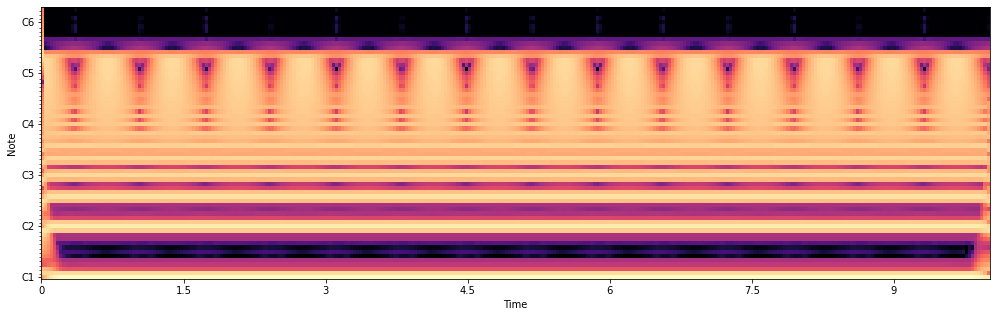

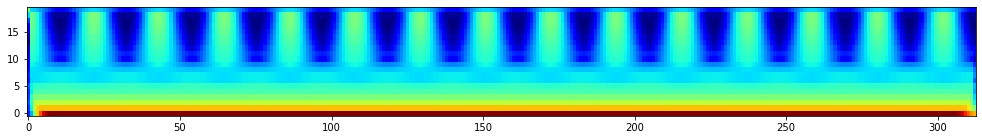

In [47]:
import numpy as np
import librosa
import librosa.display
import matplotlib.pyplot as plt
import warnings
import matplotlib.cbook
warnings.filterwarnings('ignore',category=matplotlib.cbook.mplDeprecation)

# Build a harmonic signal
sampling_frequency = 16000                                     # In Hz
time_duration = 10                                             # In seconds
time_array = np.arange(0, time_duration, 1/sampling_frequency) # In seconds
number_harmonics = 20
frequency_values = 32.70*np.arange(1, number_harmonics+1)      # in Hz
number_samples = len(time_array)
audio_signal = np.zeros(number_samples)
for frequency_value in frequency_values:
    audio_signal = audio_signal+np.sin(time_array*2*np.pi*frequency_value)

# Comptute the CQT-spectrogram of the harmonic signal
step_length = int(pow(2, int(np.ceil(np.log2(0.04*sampling_frequency))))/2)
minimum_frequency = frequency_values[0]
maximum_frequency = 2*frequency_values[-1]
octave_resolution = 12
number_frequencies = round(octave_resolution * np.log2(maximum_frequency / minimum_frequency))
cqt_spectrogram = np.abs(librosa.cqt(audio_signal, sr=sampling_frequency, hop_length=step_length, fmin=minimum_frequency, \
                                     n_bins=number_frequencies, bins_per_octave=octave_resolution))
plt.figure(figsize=(17, 5))
librosa.display.specshow(librosa.amplitude_to_db(cqt_spectrogram, ref=np.max), sr=sampling_frequency, \
                         hop_length=step_length, fmin=minimum_frequency, bins_per_octave=octave_resolution, \
                         x_axis='time', y_axis='cqt_note')
plt.show()

# Extract the CQT-spectral envelope coefficients (CQT-SEC)
coefficient_indices = np.round(octave_resolution*np.log2(np.arange(1, number_harmonics+1))).astype(int)
cqt_sec = cqt_spectrogram[coefficient_indices, :]
plt.figure(figsize=(17, 2))
plt.imshow(cqt_sec, aspect='auto', cmap='jet', origin='lower')
plt.show()

## 04. Compare the CQT-SECs to the MFCCs on one audio file

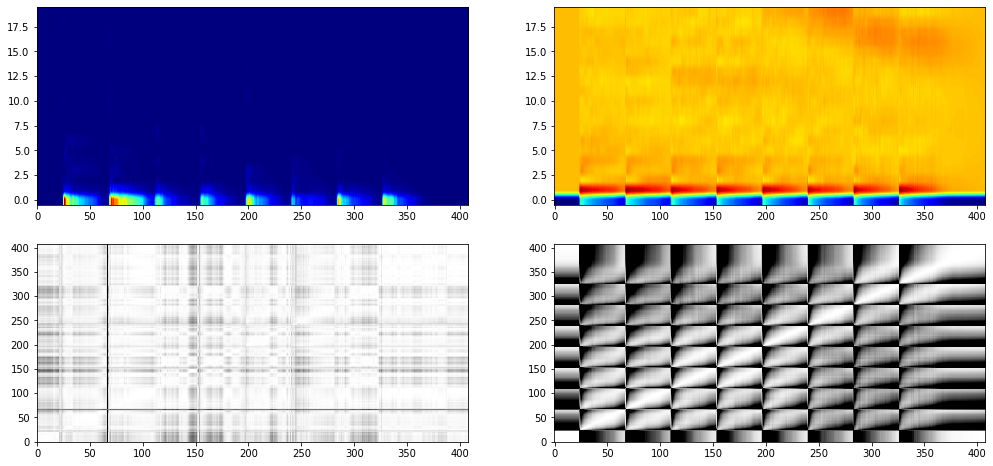

In [1]:
import numpy as np
import librosa
import librosa.display
import matplotlib.pyplot as plt

# Define a function to compute the CQT spectral envelope coefficients (CQT-SEC)
def cqtsec(audio_signal, sampling_frequency):
    
    # Comptute the CQT-spectrogram from the signal
    step_length = int(pow(2, int(np.ceil(np.log2(0.04*sampling_frequency))))/2)
    minimum_frequency = 32.70
    maximum_frequency = sampling_frequency/2
    octave_resolution = 12
    number_frequencies = round(octave_resolution * np.log2(maximum_frequency / minimum_frequency))
    cqt_spectrogram = np.abs(librosa.cqt(audio_signal, sr=sampling_frequency, hop_length=step_length, \
                                         fmin=minimum_frequency, n_bins=number_frequencies, \
                                         bins_per_octave=octave_resolution))
    
    # Derive the CQT-envelope and the CQT-pitch
    ftcqt_spectrogram = np.fft.fft(cqt_spectrogram, 2*number_frequencies-1, axis=0)
    absftcqt_spectrogram = abs(ftcqt_spectrogram)
    cqt_envelope = np.real(np.fft.ifft(absftcqt_spectrogram, axis=0)[0:number_frequencies, :])
    cqt_pitch = np.real(np.fft.ifft(ftcqt_spectrogram/absftcqt_spectrogram, axis=0)[0:number_frequencies, :])
    
    # Refine the CQT-envelope
    cqt_pitch[cqt_pitch<0] = 0
    cqt_envelope = np.real(np.fft.ifft(ftcqt_spectrogram/(np.fft.fft(cqt_pitch, 2*number_frequencies-1, axis=0)+1e-6), \
                                       axis=0)[0:number_frequencies, :])
    cqt_envelope[cqt_envelope<0] = 0
    
    # Get the indices of the CQT-SEC and extract them
    number_coefficients = 20
    coefficient_indices = np.round(octave_resolution*np.log2(np.arange(1, number_coefficients+1))).astype(int)
    cqt_sec = cqt_envelope[coefficient_indices, :]
    
    return cqt_sec


# Define a function to compute the MFCCs
def mfcc(audio_signal, sampling_frequency):
    
    # Compute the MFCCs using LibROSA's function
    window_length = pow(2, int(np.ceil(np.log2(0.04*sampling_frequency))))
    step_length = int(window_length/2)
    audio_mfcc = librosa.feature.mfcc(y=audio_signal, sr=sampling_frequency, n_fft=window_length, hop_length=step_length)
    
    return audio_mfcc


# Define a function to compute a self-similarity matrix using the cosine similarity
def ssm(audio_feature):
    
    # Normalize the columns by their Euclidean norm
    audio_feature0 = audio_feature/(np.sqrt(np.sum(np.power(audio_feature, 2), axis=0))+1e-16)
    
    # Multiple the normalized columns with each other
    similarity_matrix = np.matmul(audio_feature0.T, audio_feature0)
    
    return similarity_matrix
    
    
# Load an audio file with its sampling frequency, and keep only its left channel
file_path = r'94812__digifishmusic__c4-major-scale-piano.wav'
# file_path = r'557469__oleviolin__d-scale-violin.wav'
sampling_frequency = 16000
audio_signal, sampling_frequency = librosa.load(file_path, sr=None, mono=True)
    
# Compute the CQT-SECs and the MFCCs
cqt_sec = cqtsec(audio_signal, sampling_frequency)
audio_mfcc = mfcc(audio_signal, sampling_frequency)

# Compute the self-similarity matrices using the cosine similarity
similarity_matrix = ssm(cqt_sec)
similarity_matrix2 = ssm(audio_mfcc)

# Display everything
plt.figure(figsize=(17, 8))
plt.subplot(2, 2, 1)
plt.imshow(cqt_sec, cmap='jet', aspect='auto', origin='lower')
plt.subplot(2, 2, 2)
plt.imshow(audio_mfcc, cmap='jet', aspect='auto', origin='lower')
plt.subplot(2, 2, 3)
plt.imshow(similarity_matrix, cmap='gray', aspect='auto', origin='lower', vmin=0.9, vmax=1)
plt.subplot(2, 2, 4)
plt.imshow(similarity_matrix2, cmap='gray', aspect='auto', origin='lower', vmin=0.9, vmax=1)
plt.show()

## 04. Compare the CQT-SECs and the MFCCs on a small dataset

In [105]:
# import os
# from shutil import copyfile

# # Create a small dataset from the large NSynth dataset
# folder_path = r'C:\Users\zarafii2001\Gracenote\Data\nsynth\nsynth-train\audio'
# folder_path2 = r'C:\Users\zarafii2001\Documents\GitHub\CQT-SEC-Python\nsynth11'
# instrument_list = [{'name':'bass_acoustic', 'number': '000', 'midi': 24}, \
#                    {'name':'brass_acoustic', 'number': '000', 'midi': 60}, \
#                    {'name':'flute_acoustic', 'number': '000', 'midi': 60}, \
#                    {'name':'guitar_acoustic', 'number': '000', 'midi': 60}, \
#                    {'name':'keyboard_acoustic', 'number': '000', 'midi': 60}, \
#                    {'name':'mallet_acoustic', 'number': '000', 'midi': 72}, \
#                    {'name':'organ_electronic', 'number': '000', 'midi': 60}, \
#                    {'name':'reed_acoustic', 'number': '000', 'midi': 60}, \
#                    {'name':'string_acoustic', 'number': '000', 'midi': 60}, \
#                    {'name':'synth_lead_synthetic', 'number': '000', 'midi': 60}, \
#                    {'name':'vocal_acoustic', 'number': '002', 'midi': 60}]
# number_semitones = 12
# for i in instrument_list:
#     for j in range(i['midi'], i['midi']+number_semitones):
#         file_name = f'{i['name']}_{i['number']}-{j:03d}-075.wav'
#         file_path = os.path.join(folder_path, file_name)
#         file_path2 = os.path.join(folder_path2, file_name)
#         copyfile(file_path, file_path2)

In [3]:
import os
import numpy as np
import librosa
import matplotlib.pyplot as plt

# Define a function to compute the CQT-SEC
def cqtsec(audio_signal, sampling_frequency):
    
    # Comptute the CQT-spectrogram from the signal
    step_length = int(pow(2, int(np.ceil(np.log2(0.04*sampling_frequency))))/2)
    minimum_frequency = 32.70
    maximum_frequency = sampling_frequency/2
    octave_resolution = 12
    number_frequencies = round(octave_resolution * np.log2(maximum_frequency / minimum_frequency))
    cqt_spectrogram = np.abs(librosa.cqt(audio_signal, sr=sampling_frequency, hop_length=step_length, \
                                                  fmin=minimum_frequency, n_bins=number_frequencies, \
                                                  bins_per_octave=octave_resolution))
    
    # Compute the FT of the columns in the CQT-spectrogram and its magnitude
    ftcqt_spectrogram = np.fft.fft(cqt_spectrogram, 2*number_frequencies-1, axis=0)
    absftcqt_spectrogram = abs(ftcqt_spectrogram)
    
    # Derive the CQT-envelope and the CQT-pitch
    cqt_envelope = np.real(np.fft.ifft(absftcqt_spectrogram, axis=0)[0:number_frequencies, :])
    cqt_pitch = np.real(np.fft.ifft(ftcqt_spectrogram/(absftcqt_spectrogram+1e-16), axis=0)[0:number_frequencies, :])
    
#     # Refine the CQT-envelope
#     cqt_pitch[cqt_pitch<0] = 0
#     cqt_envelope = np.real(np.fft.ifft(ftcqt_spectrogram/(np.fft.fft(cqt_pitch, 2*number_frequencies-1, axis=0)+1e-16), \
#                                        axis=0)[0:number_frequencies, :])
#     cqt_envelope[cqt_envelope<0] = 0
    
    # Get the indices of the CQT-SEC and extract them
    number_coefficients = 20
    coefficient_indices = np.round(octave_resolution*np.log2(np.arange(1, number_coefficients+1))).astype(int)
    cqt_sec = cqt_envelope[coefficient_indices, :]


    return cqt_sec

# Define a function to compute the MFCCs
def mfcc(audio_signal, sampling_frequency):
    
    # Compute the MFCCs using LibROSA's function
    window_length = pow(2, int(np.ceil(np.log2(0.04*sampling_frequency))))
    step_length = int(window_length/2)
    audio_mfcc = librosa.feature.mfcc(y=audio_signal, sr=sampling_frequency, n_fft=window_length, hop_length=step_length)
    
    return audio_mfcc


# Path to the folder
folder_path = r'C:\Users\zarafii2001\Documents\GitHub\CQT-SEC-Python\nsynth11'
folder_listdir = os.listdir(folder_path)
number_files = len(folder_listdir)

# Create an empty list for storing dictionaries
audio_list = []

# Loop over the files
k = 0
for file_name in folder_listdir:
    k = k+1
    
#     # Display the name of the file
#     print(f'{k}/{number_files}: {file_name}')
    
    # Get the path to the audio file and load it
    file_path = os.path.join(folder_path, file_name)
    audio_signal, sampling_frequency = librosa.load(file_path, sr=None, mono=True)
    
    # Compute the CQT-SECs and the MFCCs
    cqt_sec = cqtsec(audio_signal, sampling_frequency)
    audio_mfcc = mfcc(audio_signal, sampling_frequency)
    
    # Create a dictionary for the current file and append it to the list
    audio_dict = {'name': file_name[0:-4], 'cqt-sec': cqt_sec, 'mfcc': audio_mfcc}
    audio_list.append(audio_dict)

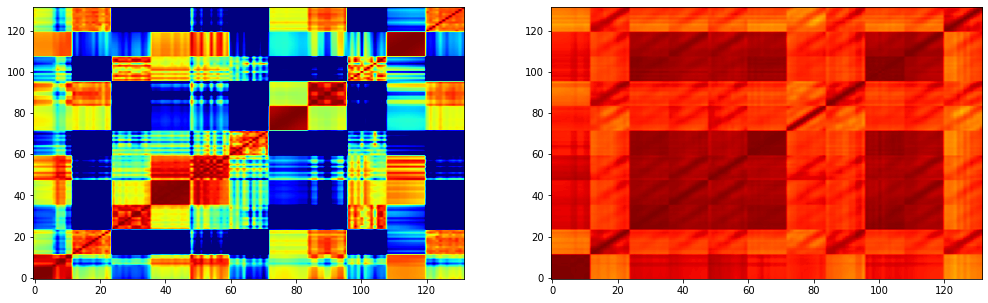

In [4]:
# Initialize the cosine similarity matrices for the CQT-SECs and the MFCCs
number_files = len(audio_list)
cqtsec_matrix = np.zeros((number_files, number_files))
mfcc_matrix = np.zeros((number_files, number_files))

# Loop over the rows of the matrices
for i in range(number_files):
    
    # Get the CQT-SECs and MFCCs for the current audio and normalize them
    cqt_sec0 = audio_list[i]['cqt-sec']
    cqt_sec0 = cqt_sec0/(np.sqrt(np.sum(np.power(cqt_sec0, 2), axis=None))+1e-16)
    audio_mfcc0 = audio_list[i]['mfcc']
    audio_mfcc0 = audio_mfcc0/(np.sqrt(np.sum(np.power(audio_mfcc0, 2), axis=None))+1e-16)
    
    # Loop over the columns of the matrices
    for j in range(number_files):
        
        # Get the CQT-SECs and MFCCs for the current audio and normalize them
        cqt_sec1 = audio_list[j]['cqt-sec']
        cqt_sec1 = cqt_sec1/(np.sqrt(np.sum(np.power(cqt_sec1, 2), axis=None))+1e-16)
        audio_mfcc1 = audio_list[j]['mfcc']
        audio_mfcc1 = audio_mfcc1/(np.sqrt(np.sum(np.power(audio_mfcc1, 2), axis=None))+1e-16)
        
        # Compute the cosine similarity between the CQT-SECs and between the MFCCs
        cqtsec_matrix[i, j] = np.sum(cqt_sec0*cqt_sec1, axis=None)
        mfcc_matrix[i, j] = np.sum(audio_mfcc0*audio_mfcc1, axis=None)
        
# Display the similarity matrices for the CQT-SECs and the MFCCs
plt.figure(figsize=(17, 5))
plt.subplot(1, 2, 1)
plt.imshow(cqtsec_matrix, cmap="jet", aspect="auto", vmin=0.5, vmax=1, origin="lower")
plt.subplot(1, 2, 2)
plt.imshow(mfcc_matrix, cmap="jet", aspect="auto", vmin=0.5, vmax=1, origin="lower")
plt.show()

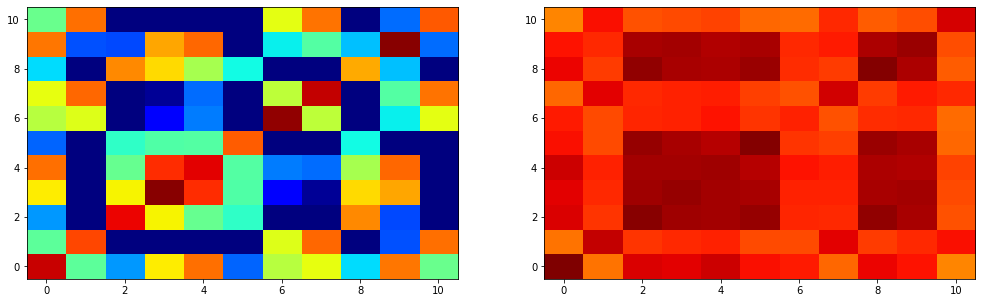

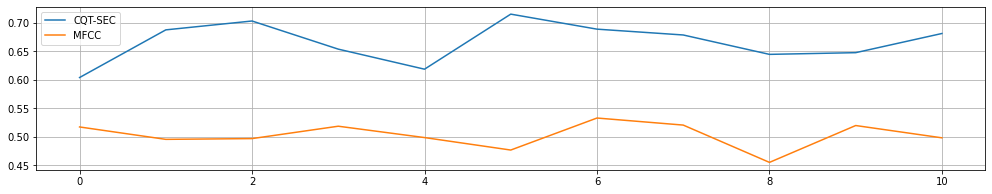

In [19]:
# Initialize the mean similarity matrices and final score vectors
number_instruments = 11
cqtsec_matrix2 = np.zeros((number_instruments, number_instruments))
mfcc_matrix2 = np.zeros((number_instruments, number_instruments))
cqtsec_vector2 = np.zeros(number_instruments)
mfcc_vector2 = np.zeros(number_instruments)

# Compute the similarity averaged over the instrument classes
for i in range(number_instruments):
    for j in range(number_instruments):
        cqtsec_matrix2[i, j] = np.mean(cqtsec_matrix[i*12:(i+1)*12, j*12:(j+1)*12])
        mfcc_matrix2[i, j] = np.mean(mfcc_matrix[i*12:(i+1)*12, j*12:(j+1)*12])

# Display the mean similarity matrices
plt.figure(figsize=(17, 5))
plt.subplot(1, 2, 1)
plt.imshow(cqtsec_matrix2, cmap="jet", aspect="auto", vmin=0.5, vmax=1, origin="lower")
plt.subplot(1, 2, 2)
plt.imshow(mfcc_matrix2, cmap="jet", aspect="auto", vmin=0.5, vmax=1, origin="lower")
plt.show()

# Compute the final score vectors (mean between self-similarity and 1 minus the averaged cross-similarities)
for i in range(number_instruments):
    cqtsec_vector2[i] = (cqtsec_matrix2[i, i] \
    + 1-((np.sum(cqtsec_matrix2[i, :])-cqtsec_matrix2[i, i])/(number_instruments-1)))/2
    mfcc_vector2[i] = (cqtsec_matrix2[i, i] \
    + 1-((np.sum(mfcc_matrix2[i, :])-mfcc_matrix2[i, i])/(number_instruments-1)))/2

# Display the final score vectors
plt.figure(figsize=(17, 3))
plt.plot(cqtsec_vector2, label='CQT-SEC')
plt.plot(mfcc_vector2, label='MFCC')
plt.grid()
plt.legend()

CQT-SEC: 0.6941282494272549
MFCC: 0.4617736634558428


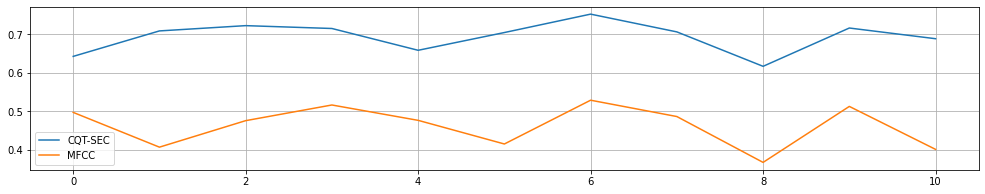

In [26]:
import os
import numpy as np
import librosa
import matplotlib.pyplot as plt

# Define a function to compute the CQT-SEC
def cqtsec(audio_signal, sampling_frequency):
    
    # Comptute the CQT-spectrogram from the signal
    step_length = int(pow(2, int(np.ceil(np.log2(0.04*sampling_frequency))))/2)
    minimum_frequency = 32.70
    maximum_frequency = sampling_frequency/2
    octave_resolution = 12
    number_frequencies = round(octave_resolution * np.log2(maximum_frequency / minimum_frequency))
    cqt_spectrogram = np.power(np.abs(librosa.cqt(audio_signal, sr=sampling_frequency, hop_length=step_length, \
                                                  fmin=minimum_frequency, n_bins=number_frequencies, \
                                                  bins_per_octave=octave_resolution)), 2)
    
    # Compute the FT of the columns in the CQT-spectrogram and its magnitude
    ftcqt_spectrogram = np.fft.fft(cqt_spectrogram, 2*number_frequencies-1, axis=0)
    absftcqt_spectrogram = abs(ftcqt_spectrogram)
    
    # Derive the CQT-envelope and the CQT-pitch
    cqt_envelope = np.real(np.fft.ifft(absftcqt_spectrogram, axis=0)[0:number_frequencies, :])
    cqt_pitch = np.real(np.fft.ifft(ftcqt_spectrogram/(absftcqt_spectrogram+1e-16), axis=0)[0:number_frequencies, :])
    
#     # Refine the CQT-envelope
#     cqt_pitch[cqt_pitch<0] = 0
#     cqt_envelope = np.real(np.fft.ifft(ftcqt_spectrogram/(np.fft.fft(cqt_pitch, 2*number_frequencies-1, axis=0)+1e-16), \
#                                        axis=0)[0:number_frequencies, :])
#     cqt_envelope[cqt_envelope<0] = 0
    
    # Get the indices of the CQT-SEC and extract them
    number_coefficients = 20
    coefficient_indices = np.round(octave_resolution*np.log2(np.arange(1, number_coefficients+1))).astype(int)
    cqt_sec = cqt_envelope[coefficient_indices, :]


    return cqt_sec

# Define a function to compute the MFCCs
def mfcc(audio_signal, sampling_frequency):
    
    # Compute the MFCCs using LibROSA's function
    window_length = pow(2, int(np.ceil(np.log2(0.04*sampling_frequency))))
    step_length = int(window_length/2)
    audio_mfcc = librosa.feature.mfcc(y=audio_signal, sr=sampling_frequency, n_fft=window_length, hop_length=step_length)
    
    return audio_mfcc


# Path to the folder
folder_path = r'C:\Users\zarafii2001\Documents\GitHub\CQT-SEC-Python\nsynth11'
folder_listdir = os.listdir(folder_path)
number_files = len(folder_listdir)

# Create an empty list for storing dictionaries
audio_list = []

# Loop over the files
k = 0
for file_name in folder_listdir:
    k = k+1
    
#     # Display the name of the file
#     print(f'{k}/{number_files}: {file_name}')
    
    # Get the path to the audio file and load it
    file_path = os.path.join(folder_path, file_name)
    audio_signal, sampling_frequency = librosa.load(file_path, sr=None, mono=True)
    
    # Compute the CQT-SECs and the MFCCs
    cqt_sec = cqtsec(audio_signal, sampling_frequency)
    audio_mfcc = mfcc(audio_signal, sampling_frequency)
    
    # Create a dictionary for the current file and append it to the list
    audio_dict = {'name': file_name[0:-4], 'cqt-sec': cqt_sec, 'mfcc': audio_mfcc}
    audio_list.append(audio_dict)
    

# Initialize the cosine similarity matrices for the CQT-SECs and the MFCCs
number_files = len(audio_list)
cqtsec_matrix = np.zeros((number_files, number_files))
mfcc_matrix = np.zeros((number_files, number_files))

# Loop over the rows of the matrices
for i in range(number_files):
    
    # Get the CQT-SECs and MFCCs for the current audio and normalize them
    cqt_sec0 = audio_list[i]['cqt-sec']
    cqt_sec0 = cqt_sec0/(np.sqrt(np.sum(np.power(cqt_sec0, 2), axis=None))+1e-16)
    audio_mfcc0 = audio_list[i]['mfcc']
    audio_mfcc0 = audio_mfcc0/(np.sqrt(np.sum(np.power(audio_mfcc0, 2), axis=None))+1e-16)
    
    # Loop over the columns of the matrices
    for j in range(number_files):
        
        # Get the CQT-SECs and MFCCs for the current audio and normalize them
        cqt_sec1 = audio_list[j]['cqt-sec']
        cqt_sec1 = cqt_sec1/(np.sqrt(np.sum(np.power(cqt_sec1, 2), axis=None))+1e-16)
        audio_mfcc1 = audio_list[j]['mfcc']
        audio_mfcc1 = audio_mfcc1/(np.sqrt(np.sum(np.power(audio_mfcc1, 2), axis=None))+1e-16)
        
        # Compute the cosine similarity between the CQT-SECs and between the MFCCs
        cqtsec_matrix[i, j] = np.sum(cqt_sec0*cqt_sec1, axis=None)
        mfcc_matrix[i, j] = np.sum(audio_mfcc0*audio_mfcc1, axis=None)
        
# Initialize the mean similarity matrices and final score vectors
number_instruments = 11
cqtsec_matrix2 = np.zeros((number_instruments, number_instruments))
mfcc_matrix2 = np.zeros((number_instruments, number_instruments))
cqtsec_vector2 = np.zeros(number_instruments)
mfcc_vector2 = np.zeros(number_instruments)

# Compute the similarity averaged over the instrument classes
for i in range(number_instruments):
    for j in range(number_instruments):
        cqtsec_matrix2[i, j] = np.mean(cqtsec_matrix[i*12:(i+1)*12, j*12:(j+1)*12])
        mfcc_matrix2[i, j] = np.mean(mfcc_matrix[i*12:(i+1)*12, j*12:(j+1)*12])

# Compute the final score vectors (mean between self-similarity and 1 minus the averaged cross-similarities)
for i in range(number_instruments):
    cqtsec_vector2[i] = (cqtsec_matrix2[i, i] \
    + 1-((np.sum(cqtsec_matrix2[i, :])-cqtsec_matrix2[i, i])/(number_instruments-1)))/2
    mfcc_vector2[i] = (cqtsec_matrix2[i, i] \
    + 1-((np.sum(mfcc_matrix2[i, :])-mfcc_matrix2[i, i])/(number_instruments-1)))/2

# Display the final score vectors
plt.figure(figsize=(17, 3))
plt.plot(cqtsec_vector2, label='CQT-SEC')
plt.plot(mfcc_vector2, label='MFCC')
plt.grid()
plt.legend()

print(f'CQT-SEC: {np.mean(cqtsec_vector2)}')
print(f'MFCC: {np.mean(mfcc_vector2)}')

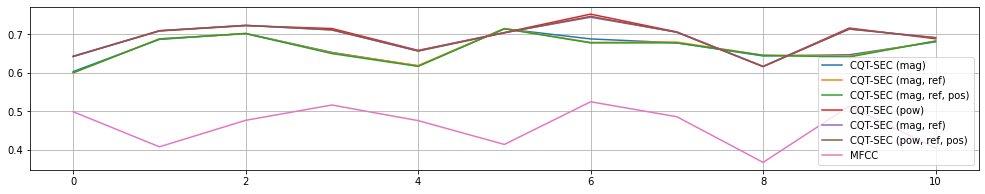

In [33]:
import os
import numpy as np
import librosa
import matplotlib.pyplot as plt

plt.figure(figsize=(17, 3))



# Define a function to compute the CQT-SEC
def cqtsec(audio_signal, sampling_frequency):
    
    # Comptute the CQT-spectrogram from the signal
    step_length = int(pow(2, int(np.ceil(np.log2(0.04*sampling_frequency))))/2)
    minimum_frequency = 32.70
    maximum_frequency = sampling_frequency/2
    octave_resolution = 12
    number_frequencies = round(octave_resolution * np.log2(maximum_frequency / minimum_frequency))
    cqt_spectrogram = np.abs(librosa.cqt(audio_signal, sr=sampling_frequency, hop_length=step_length, \
                                                  fmin=minimum_frequency, n_bins=number_frequencies, \
                                                  bins_per_octave=octave_resolution))
    
    # Compute the FT of the columns in the CQT-spectrogram and its magnitude
    ftcqt_spectrogram = np.fft.fft(cqt_spectrogram, 2*number_frequencies-1, axis=0)
    absftcqt_spectrogram = abs(ftcqt_spectrogram)
    
    # Derive the CQT-envelope and the CQT-pitch
    cqt_envelope = np.real(np.fft.ifft(absftcqt_spectrogram, axis=0)[0:number_frequencies, :])
    cqt_pitch = np.real(np.fft.ifft(ftcqt_spectrogram/(absftcqt_spectrogram+1e-16), axis=0)[0:number_frequencies, :])
    
#     # Refine the CQT-envelope
#     cqt_pitch[cqt_pitch<0] = 0
#     cqt_envelope = np.real(np.fft.ifft(ftcqt_spectrogram/(np.fft.fft(cqt_pitch, 2*number_frequencies-1, axis=0)+1e-16), \
#                                        axis=0)[0:number_frequencies, :])
#     cqt_envelope[cqt_envelope<0] = 0
    
    # Get the indices of the CQT-SEC and extract them
    number_coefficients = 20
    coefficient_indices = np.round(octave_resolution*np.log2(np.arange(1, number_coefficients+1))).astype(int)
    cqt_sec = cqt_envelope[coefficient_indices, :]
    
    return cqt_sec

# Define a function to compute the MFCCs
def mfcc(audio_signal, sampling_frequency):
    
    # Compute the MFCCs using LibROSA's function
    window_length = pow(2, int(np.ceil(np.log2(0.04*sampling_frequency))))
    step_length = int(window_length/2)
    audio_mfcc = librosa.feature.mfcc(y=audio_signal, sr=sampling_frequency, n_fft=window_length, hop_length=step_length)
    
    return audio_mfcc


# Path to the folder
folder_path = r'C:\Users\zarafii2001\Documents\GitHub\CQT-SEC-Python\nsynth11'
folder_listdir = os.listdir(folder_path)
number_files = len(folder_listdir)

# Create an empty list for storing dictionaries
audio_list = []

# Loop over the files
k = 0
for file_name in folder_listdir:
    k = k+1
    
#     # Display the name of the file
#     print(f'{k}/{number_files}: {file_name}')
    
    # Get the path to the audio file and load it
    file_path = os.path.join(folder_path, file_name)
    audio_signal, sampling_frequency = librosa.load(file_path, sr=None, mono=True)
    
    # Compute the CQT-SECs and the MFCCs
    cqt_sec = cqtsec(audio_signal, sampling_frequency)
    audio_mfcc = mfcc(audio_signal, sampling_frequency)
    
    # Create a dictionary for the current file and append it to the list
    audio_dict = {'name': file_name[0:-4], 'cqt-sec': cqt_sec, 'mfcc': audio_mfcc}
    audio_list.append(audio_dict)
    

# Initialize the cosine similarity matrices for the CQT-SECs and the MFCCs
number_files = len(audio_list)
cqtsec_matrix = np.zeros((number_files, number_files))
mfcc_matrix = np.zeros((number_files, number_files))

# Loop over the rows of the matrices
for i in range(number_files):
    
    # Get the CQT-SECs and MFCCs for the current audio and normalize them
    cqt_sec0 = audio_list[i]['cqt-sec']
    cqt_sec0 = cqt_sec0/(np.sqrt(np.sum(np.power(cqt_sec0, 2), axis=None))+1e-16)
    audio_mfcc0 = audio_list[i]['mfcc']
    audio_mfcc0 = audio_mfcc0/(np.sqrt(np.sum(np.power(audio_mfcc0, 2), axis=None))+1e-16)
    
    # Loop over the columns of the matrices
    for j in range(number_files):
        
        # Get the CQT-SECs and MFCCs for the current audio and normalize them
        cqt_sec1 = audio_list[j]['cqt-sec']
        cqt_sec1 = cqt_sec1/(np.sqrt(np.sum(np.power(cqt_sec1, 2), axis=None))+1e-16)
        audio_mfcc1 = audio_list[j]['mfcc']
        audio_mfcc1 = audio_mfcc1/(np.sqrt(np.sum(np.power(audio_mfcc1, 2), axis=None))+1e-16)
        
        # Compute the cosine similarity between the CQT-SECs and between the MFCCs
        cqtsec_matrix[i, j] = np.sum(cqt_sec0*cqt_sec1, axis=None)
        mfcc_matrix[i, j] = np.sum(audio_mfcc0*audio_mfcc1, axis=None)
        
# Initialize the mean similarity matrices and final score vectors
number_instruments = 11
cqtsec_matrix2 = np.zeros((number_instruments, number_instruments))
mfcc_matrix2 = np.zeros((number_instruments, number_instruments))
cqtsec_vector2 = np.zeros(number_instruments)
mfcc_vector2 = np.zeros(number_instruments)

# Compute the similarity averaged over the instrument classes
for i in range(number_instruments):
    for j in range(number_instruments):
        cqtsec_matrix2[i, j] = np.mean(cqtsec_matrix[i*12:(i+1)*12, j*12:(j+1)*12])
        mfcc_matrix2[i, j] = np.mean(mfcc_matrix[i*12:(i+1)*12, j*12:(j+1)*12])

# Compute the final score vectors (mean between self-similarity and 1 minus the averaged cross-similarities)
for i in range(number_instruments):
    cqtsec_vector2[i] = (cqtsec_matrix2[i, i] \
    + 1-((np.sum(cqtsec_matrix2[i, :])-cqtsec_matrix2[i, i])/(number_instruments-1)))/2
    mfcc_vector2[i] = (cqtsec_matrix2[i, i] \
    + 1-((np.sum(mfcc_matrix2[i, :])-mfcc_matrix2[i, i])/(number_instruments-1)))/2

# Display the final score vectors
plt.plot(cqtsec_vector2, label='CQT-SEC (mag)')



# Define a function to compute the CQT-SEC
def cqtsec(audio_signal, sampling_frequency):
    
    # Comptute the CQT-spectrogram from the signal
    step_length = int(pow(2, int(np.ceil(np.log2(0.04*sampling_frequency))))/2)
    minimum_frequency = 32.70
    maximum_frequency = sampling_frequency/2
    octave_resolution = 12
    number_frequencies = round(octave_resolution * np.log2(maximum_frequency / minimum_frequency))
    cqt_spectrogram = np.abs(librosa.cqt(audio_signal, sr=sampling_frequency, hop_length=step_length, \
                                                  fmin=minimum_frequency, n_bins=number_frequencies, \
                                                  bins_per_octave=octave_resolution))
    
    # Compute the FT of the columns in the CQT-spectrogram and its magnitude
    ftcqt_spectrogram = np.fft.fft(cqt_spectrogram, 2*number_frequencies-1, axis=0)
    absftcqt_spectrogram = abs(ftcqt_spectrogram)
    
    # Derive the CQT-envelope and the CQT-pitch
    cqt_envelope = np.real(np.fft.ifft(absftcqt_spectrogram, axis=0)[0:number_frequencies, :])
    cqt_pitch = np.real(np.fft.ifft(ftcqt_spectrogram/(absftcqt_spectrogram+1e-16), axis=0)[0:number_frequencies, :])
    
    # Refine the CQT-envelope
    cqt_pitch[cqt_pitch<0] = 0
    cqt_envelope = np.real(np.fft.ifft(ftcqt_spectrogram/(np.fft.fft(cqt_pitch, 2*number_frequencies-1, axis=0)+1e-16), \
                                       axis=0)[0:number_frequencies, :])
#     cqt_envelope[cqt_envelope<0] = 0
    
    # Get the indices of the CQT-SEC and extract them
    number_coefficients = 20
    coefficient_indices = np.round(octave_resolution*np.log2(np.arange(1, number_coefficients+1))).astype(int)
    cqt_sec = cqt_envelope[coefficient_indices, :]

    return cqt_sec

# Define a function to compute the MFCCs
def mfcc(audio_signal, sampling_frequency):
    
    # Compute the MFCCs using LibROSA's function
    window_length = pow(2, int(np.ceil(np.log2(0.04*sampling_frequency))))
    step_length = int(window_length/2)
    audio_mfcc = librosa.feature.mfcc(y=audio_signal, sr=sampling_frequency, n_fft=window_length, hop_length=step_length)
    
    return audio_mfcc


# Path to the folder
folder_path = r'C:\Users\zarafii2001\Documents\GitHub\CQT-SEC-Python\nsynth11'
folder_listdir = os.listdir(folder_path)
number_files = len(folder_listdir)

# Create an empty list for storing dictionaries
audio_list = []

# Loop over the files
k = 0
for file_name in folder_listdir:
    k = k+1
    
#     # Display the name of the file
#     print(f'{k}/{number_files}: {file_name}')
    
    # Get the path to the audio file and load it
    file_path = os.path.join(folder_path, file_name)
    audio_signal, sampling_frequency = librosa.load(file_path, sr=None, mono=True)
    
    # Compute the CQT-SECs and the MFCCs
    cqt_sec = cqtsec(audio_signal, sampling_frequency)
    audio_mfcc = mfcc(audio_signal, sampling_frequency)
    
    # Create a dictionary for the current file and append it to the list
    audio_dict = {'name': file_name[0:-4], 'cqt-sec': cqt_sec, 'mfcc': audio_mfcc}
    audio_list.append(audio_dict)
    

# Initialize the cosine similarity matrices for the CQT-SECs and the MFCCs
number_files = len(audio_list)
cqtsec_matrix = np.zeros((number_files, number_files))
mfcc_matrix = np.zeros((number_files, number_files))

# Loop over the rows of the matrices
for i in range(number_files):
    
    # Get the CQT-SECs and MFCCs for the current audio and normalize them
    cqt_sec0 = audio_list[i]['cqt-sec']
    cqt_sec0 = cqt_sec0/(np.sqrt(np.sum(np.power(cqt_sec0, 2), axis=None))+1e-16)
    audio_mfcc0 = audio_list[i]['mfcc']
    audio_mfcc0 = audio_mfcc0/(np.sqrt(np.sum(np.power(audio_mfcc0, 2), axis=None))+1e-16)
    
    # Loop over the columns of the matrices
    for j in range(number_files):
        
        # Get the CQT-SECs and MFCCs for the current audio and normalize them
        cqt_sec1 = audio_list[j]['cqt-sec']
        cqt_sec1 = cqt_sec1/(np.sqrt(np.sum(np.power(cqt_sec1, 2), axis=None))+1e-16)
        audio_mfcc1 = audio_list[j]['mfcc']
        audio_mfcc1 = audio_mfcc1/(np.sqrt(np.sum(np.power(audio_mfcc1, 2), axis=None))+1e-16)
        
        # Compute the cosine similarity between the CQT-SECs and between the MFCCs
        cqtsec_matrix[i, j] = np.sum(cqt_sec0*cqt_sec1, axis=None)
        mfcc_matrix[i, j] = np.sum(audio_mfcc0*audio_mfcc1, axis=None)
        
# Initialize the mean similarity matrices and final score vectors
number_instruments = 11
cqtsec_matrix2 = np.zeros((number_instruments, number_instruments))
mfcc_matrix2 = np.zeros((number_instruments, number_instruments))
cqtsec_vector2 = np.zeros(number_instruments)
mfcc_vector2 = np.zeros(number_instruments)

# Compute the similarity averaged over the instrument classes
for i in range(number_instruments):
    for j in range(number_instruments):
        cqtsec_matrix2[i, j] = np.mean(cqtsec_matrix[i*12:(i+1)*12, j*12:(j+1)*12])
        mfcc_matrix2[i, j] = np.mean(mfcc_matrix[i*12:(i+1)*12, j*12:(j+1)*12])

# Compute the final score vectors (mean between self-similarity and 1 minus the averaged cross-similarities)
for i in range(number_instruments):
    cqtsec_vector2[i] = (cqtsec_matrix2[i, i] \
    + 1-((np.sum(cqtsec_matrix2[i, :])-cqtsec_matrix2[i, i])/(number_instruments-1)))/2
    mfcc_vector2[i] = (cqtsec_matrix2[i, i] \
    + 1-((np.sum(mfcc_matrix2[i, :])-mfcc_matrix2[i, i])/(number_instruments-1)))/2

# Display the final score vectors
plt.plot(cqtsec_vector2, label='CQT-SEC (mag, ref)')



# Define a function to compute the CQT-SEC
def cqtsec(audio_signal, sampling_frequency):
    
    # Comptute the CQT-spectrogram from the signal
    step_length = int(pow(2, int(np.ceil(np.log2(0.04*sampling_frequency))))/2)
    minimum_frequency = 32.70
    maximum_frequency = sampling_frequency/2
    octave_resolution = 12
    number_frequencies = round(octave_resolution * np.log2(maximum_frequency / minimum_frequency))
    cqt_spectrogram = np.abs(librosa.cqt(audio_signal, sr=sampling_frequency, hop_length=step_length, \
                                                  fmin=minimum_frequency, n_bins=number_frequencies, \
                                                  bins_per_octave=octave_resolution))
    
    # Compute the FT of the columns in the CQT-spectrogram and its magnitude
    ftcqt_spectrogram = np.fft.fft(cqt_spectrogram, 2*number_frequencies-1, axis=0)
    absftcqt_spectrogram = abs(ftcqt_spectrogram)
    
    # Derive the CQT-envelope and the CQT-pitch
    cqt_envelope = np.real(np.fft.ifft(absftcqt_spectrogram, axis=0)[0:number_frequencies, :])
    cqt_pitch = np.real(np.fft.ifft(ftcqt_spectrogram/(absftcqt_spectrogram+1e-16), axis=0)[0:number_frequencies, :])
    
    # Refine the CQT-envelope
    cqt_pitch[cqt_pitch<0] = 0
    cqt_envelope = np.real(np.fft.ifft(ftcqt_spectrogram/(np.fft.fft(cqt_pitch, 2*number_frequencies-1, axis=0)+1e-16), \
                                       axis=0)[0:number_frequencies, :])
    cqt_envelope[cqt_envelope<0] = 0
    
    # Get the indices of the CQT-SEC and extract them
    number_coefficients = 20
    coefficient_indices = np.round(octave_resolution*np.log2(np.arange(1, number_coefficients+1))).astype(int)
    cqt_sec = cqt_envelope[coefficient_indices, :]

    return cqt_sec

# Define a function to compute the MFCCs
def mfcc(audio_signal, sampling_frequency):
    
    # Compute the MFCCs using LibROSA's function
    window_length = pow(2, int(np.ceil(np.log2(0.04*sampling_frequency))))
    step_length = int(window_length/2)
    audio_mfcc = librosa.feature.mfcc(y=audio_signal, sr=sampling_frequency, n_fft=window_length, hop_length=step_length)
    
    return audio_mfcc


# Path to the folder
folder_path = r'C:\Users\zarafii2001\Documents\GitHub\CQT-SEC-Python\nsynth11'
folder_listdir = os.listdir(folder_path)
number_files = len(folder_listdir)

# Create an empty list for storing dictionaries
audio_list = []

# Loop over the files
k = 0
for file_name in folder_listdir:
    k = k+1
    
#     # Display the name of the file
#     print(f'{k}/{number_files}: {file_name}')
    
    # Get the path to the audio file and load it
    file_path = os.path.join(folder_path, file_name)
    audio_signal, sampling_frequency = librosa.load(file_path, sr=None, mono=True)
    
    # Compute the CQT-SECs and the MFCCs
    cqt_sec = cqtsec(audio_signal, sampling_frequency)
    audio_mfcc = mfcc(audio_signal, sampling_frequency)
    
    # Create a dictionary for the current file and append it to the list
    audio_dict = {'name': file_name[0:-4], 'cqt-sec': cqt_sec, 'mfcc': audio_mfcc}
    audio_list.append(audio_dict)
    

# Initialize the cosine similarity matrices for the CQT-SECs and the MFCCs
number_files = len(audio_list)
cqtsec_matrix = np.zeros((number_files, number_files))
mfcc_matrix = np.zeros((number_files, number_files))

# Loop over the rows of the matrices
for i in range(number_files):
    
    # Get the CQT-SECs and MFCCs for the current audio and normalize them
    cqt_sec0 = audio_list[i]['cqt-sec']
    cqt_sec0 = cqt_sec0/(np.sqrt(np.sum(np.power(cqt_sec0, 2), axis=None))+1e-16)
    audio_mfcc0 = audio_list[i]['mfcc']
    audio_mfcc0 = audio_mfcc0/(np.sqrt(np.sum(np.power(audio_mfcc0, 2), axis=None))+1e-16)
    
    # Loop over the columns of the matrices
    for j in range(number_files):
        
        # Get the CQT-SECs and MFCCs for the current audio and normalize them
        cqt_sec1 = audio_list[j]['cqt-sec']
        cqt_sec1 = cqt_sec1/(np.sqrt(np.sum(np.power(cqt_sec1, 2), axis=None))+1e-16)
        audio_mfcc1 = audio_list[j]['mfcc']
        audio_mfcc1 = audio_mfcc1/(np.sqrt(np.sum(np.power(audio_mfcc1, 2), axis=None))+1e-16)
        
        # Compute the cosine similarity between the CQT-SECs and between the MFCCs
        cqtsec_matrix[i, j] = np.sum(cqt_sec0*cqt_sec1, axis=None)
        mfcc_matrix[i, j] = np.sum(audio_mfcc0*audio_mfcc1, axis=None)
        
# Initialize the mean similarity matrices and final score vectors
number_instruments = 11
cqtsec_matrix2 = np.zeros((number_instruments, number_instruments))
mfcc_matrix2 = np.zeros((number_instruments, number_instruments))
cqtsec_vector2 = np.zeros(number_instruments)
mfcc_vector2 = np.zeros(number_instruments)

# Compute the similarity averaged over the instrument classes
for i in range(number_instruments):
    for j in range(number_instruments):
        cqtsec_matrix2[i, j] = np.mean(cqtsec_matrix[i*12:(i+1)*12, j*12:(j+1)*12])
        mfcc_matrix2[i, j] = np.mean(mfcc_matrix[i*12:(i+1)*12, j*12:(j+1)*12])

# Compute the final score vectors (mean between self-similarity and 1 minus the averaged cross-similarities)
for i in range(number_instruments):
    cqtsec_vector2[i] = (cqtsec_matrix2[i, i] \
    + 1-((np.sum(cqtsec_matrix2[i, :])-cqtsec_matrix2[i, i])/(number_instruments-1)))/2
    mfcc_vector2[i] = (cqtsec_matrix2[i, i] \
    + 1-((np.sum(mfcc_matrix2[i, :])-mfcc_matrix2[i, i])/(number_instruments-1)))/2

# Display the final score vectors
plt.plot(cqtsec_vector2, label='CQT-SEC (mag, ref, pos)')



# Define a function to compute the CQT-SEC
def cqtsec(audio_signal, sampling_frequency):
    
    # Comptute the CQT-spectrogram from the signal
    step_length = int(pow(2, int(np.ceil(np.log2(0.04*sampling_frequency))))/2)
    minimum_frequency = 32.70
    maximum_frequency = sampling_frequency/2
    octave_resolution = 12
    number_frequencies = round(octave_resolution * np.log2(maximum_frequency / minimum_frequency))
    cqt_spectrogram = np.power(np.abs(librosa.cqt(audio_signal, sr=sampling_frequency, hop_length=step_length, \
                                                  fmin=minimum_frequency, n_bins=number_frequencies, \
                                                  bins_per_octave=octave_resolution)), 2)
    
    # Compute the FT of the columns in the CQT-spectrogram and its magnitude
    ftcqt_spectrogram = np.fft.fft(cqt_spectrogram, 2*number_frequencies-1, axis=0)
    absftcqt_spectrogram = abs(ftcqt_spectrogram)
    
    # Derive the CQT-envelope and the CQT-pitch
    cqt_envelope = np.real(np.fft.ifft(absftcqt_spectrogram, axis=0)[0:number_frequencies, :])
    cqt_pitch = np.real(np.fft.ifft(ftcqt_spectrogram/(absftcqt_spectrogram+1e-16), axis=0)[0:number_frequencies, :])
    
#     # Refine the CQT-envelope
#     cqt_pitch[cqt_pitch<0] = 0
#     cqt_envelope = np.real(np.fft.ifft(ftcqt_spectrogram/(np.fft.fft(cqt_pitch, 2*number_frequencies-1, axis=0)+1e-16), \
#                                        axis=0)[0:number_frequencies, :])
#     cqt_envelope[cqt_envelope<0] = 0
    
    # Get the indices of the CQT-SEC and extract them
    number_coefficients = 20
    coefficient_indices = np.round(octave_resolution*np.log2(np.arange(1, number_coefficients+1))).astype(int)
    cqt_sec = cqt_envelope[coefficient_indices, :]

    return cqt_sec

# Define a function to compute the MFCCs
def mfcc(audio_signal, sampling_frequency):
    
    # Compute the MFCCs using LibROSA's function
    window_length = pow(2, int(np.ceil(np.log2(0.04*sampling_frequency))))
    step_length = int(window_length/2)
    audio_mfcc = librosa.feature.mfcc(y=audio_signal, sr=sampling_frequency, n_fft=window_length, hop_length=step_length)
    
    return audio_mfcc


# Path to the folder
folder_path = r'C:\Users\zarafii2001\Documents\GitHub\CQT-SEC-Python\nsynth11'
folder_listdir = os.listdir(folder_path)
number_files = len(folder_listdir)

# Create an empty list for storing dictionaries
audio_list = []

# Loop over the files
k = 0
for file_name in folder_listdir:
    k = k+1
    
#     # Display the name of the file
#     print(f'{k}/{number_files}: {file_name}')
    
    # Get the path to the audio file and load it
    file_path = os.path.join(folder_path, file_name)
    audio_signal, sampling_frequency = librosa.load(file_path, sr=None, mono=True)
    
    # Compute the CQT-SECs and the MFCCs
    cqt_sec = cqtsec(audio_signal, sampling_frequency)
    audio_mfcc = mfcc(audio_signal, sampling_frequency)
    
    # Create a dictionary for the current file and append it to the list
    audio_dict = {'name': file_name[0:-4], 'cqt-sec': cqt_sec, 'mfcc': audio_mfcc}
    audio_list.append(audio_dict)
    

# Initialize the cosine similarity matrices for the CQT-SECs and the MFCCs
number_files = len(audio_list)
cqtsec_matrix = np.zeros((number_files, number_files))
mfcc_matrix = np.zeros((number_files, number_files))

# Loop over the rows of the matrices
for i in range(number_files):
    
    # Get the CQT-SECs and MFCCs for the current audio and normalize them
    cqt_sec0 = audio_list[i]['cqt-sec']
    cqt_sec0 = cqt_sec0/(np.sqrt(np.sum(np.power(cqt_sec0, 2), axis=None))+1e-16)
    audio_mfcc0 = audio_list[i]['mfcc']
    audio_mfcc0 = audio_mfcc0/(np.sqrt(np.sum(np.power(audio_mfcc0, 2), axis=None))+1e-16)
    
    # Loop over the columns of the matrices
    for j in range(number_files):
        
        # Get the CQT-SECs and MFCCs for the current audio and normalize them
        cqt_sec1 = audio_list[j]['cqt-sec']
        cqt_sec1 = cqt_sec1/(np.sqrt(np.sum(np.power(cqt_sec1, 2), axis=None))+1e-16)
        audio_mfcc1 = audio_list[j]['mfcc']
        audio_mfcc1 = audio_mfcc1/(np.sqrt(np.sum(np.power(audio_mfcc1, 2), axis=None))+1e-16)
        
        # Compute the cosine similarity between the CQT-SECs and between the MFCCs
        cqtsec_matrix[i, j] = np.sum(cqt_sec0*cqt_sec1, axis=None)
        mfcc_matrix[i, j] = np.sum(audio_mfcc0*audio_mfcc1, axis=None)
        
# Initialize the mean similarity matrices and final score vectors
number_instruments = 11
cqtsec_matrix2 = np.zeros((number_instruments, number_instruments))
mfcc_matrix2 = np.zeros((number_instruments, number_instruments))
cqtsec_vector2 = np.zeros(number_instruments)
mfcc_vector2 = np.zeros(number_instruments)

# Compute the similarity averaged over the instrument classes
for i in range(number_instruments):
    for j in range(number_instruments):
        cqtsec_matrix2[i, j] = np.mean(cqtsec_matrix[i*12:(i+1)*12, j*12:(j+1)*12])
        mfcc_matrix2[i, j] = np.mean(mfcc_matrix[i*12:(i+1)*12, j*12:(j+1)*12])

# Compute the final score vectors (mean between self-similarity and 1 minus the averaged cross-similarities)
for i in range(number_instruments):
    cqtsec_vector2[i] = (cqtsec_matrix2[i, i] \
    + 1-((np.sum(cqtsec_matrix2[i, :])-cqtsec_matrix2[i, i])/(number_instruments-1)))/2
    mfcc_vector2[i] = (cqtsec_matrix2[i, i] \
    + 1-((np.sum(mfcc_matrix2[i, :])-mfcc_matrix2[i, i])/(number_instruments-1)))/2

# Display the final score vectors
plt.plot(cqtsec_vector2, label='CQT-SEC (pow)')



# Define a function to compute the CQT-SEC
def cqtsec(audio_signal, sampling_frequency):
    
    # Comptute the CQT-spectrogram from the signal
    step_length = int(pow(2, int(np.ceil(np.log2(0.04*sampling_frequency))))/2)
    minimum_frequency = 32.70
    maximum_frequency = sampling_frequency/2
    octave_resolution = 12
    number_frequencies = round(octave_resolution * np.log2(maximum_frequency / minimum_frequency))
    cqt_spectrogram = np.power(np.abs(librosa.cqt(audio_signal, sr=sampling_frequency, hop_length=step_length, \
                                                  fmin=minimum_frequency, n_bins=number_frequencies, \
                                                  bins_per_octave=octave_resolution)), 2)
    
    # Compute the FT of the columns in the CQT-spectrogram and its magnitude
    ftcqt_spectrogram = np.fft.fft(cqt_spectrogram, 2*number_frequencies-1, axis=0)
    absftcqt_spectrogram = abs(ftcqt_spectrogram)
    
    # Derive the CQT-envelope and the CQT-pitch
    cqt_envelope = np.real(np.fft.ifft(absftcqt_spectrogram, axis=0)[0:number_frequencies, :])
    cqt_pitch = np.real(np.fft.ifft(ftcqt_spectrogram/(absftcqt_spectrogram+1e-16), axis=0)[0:number_frequencies, :])
    
    # Refine the CQT-envelope
    cqt_pitch[cqt_pitch<0] = 0
    cqt_envelope = np.real(np.fft.ifft(ftcqt_spectrogram/(np.fft.fft(cqt_pitch, 2*number_frequencies-1, axis=0)+1e-16), \
                                       axis=0)[0:number_frequencies, :])
#     cqt_envelope[cqt_envelope<0] = 0
    
    # Get the indices of the CQT-SEC and extract them
    number_coefficients = 20
    coefficient_indices = np.round(octave_resolution*np.log2(np.arange(1, number_coefficients+1))).astype(int)
    cqt_sec = cqt_envelope[coefficient_indices, :]

    return cqt_sec

# Define a function to compute the MFCCs
def mfcc(audio_signal, sampling_frequency):
    
    # Compute the MFCCs using LibROSA's function
    window_length = pow(2, int(np.ceil(np.log2(0.04*sampling_frequency))))
    step_length = int(window_length/2)
    audio_mfcc = librosa.feature.mfcc(y=audio_signal, sr=sampling_frequency, n_fft=window_length, hop_length=step_length)
    
    return audio_mfcc


# Path to the folder
folder_path = r'C:\Users\zarafii2001\Documents\GitHub\CQT-SEC-Python\nsynth11'
folder_listdir = os.listdir(folder_path)
number_files = len(folder_listdir)

# Create an empty list for storing dictionaries
audio_list = []

# Loop over the files
k = 0
for file_name in folder_listdir:
    k = k+1
    
#     # Display the name of the file
#     print(f'{k}/{number_files}: {file_name}')
    
    # Get the path to the audio file and load it
    file_path = os.path.join(folder_path, file_name)
    audio_signal, sampling_frequency = librosa.load(file_path, sr=None, mono=True)
    
    # Compute the CQT-SECs and the MFCCs
    cqt_sec = cqtsec(audio_signal, sampling_frequency)
    audio_mfcc = mfcc(audio_signal, sampling_frequency)
    
    # Create a dictionary for the current file and append it to the list
    audio_dict = {'name': file_name[0:-4], 'cqt-sec': cqt_sec, 'mfcc': audio_mfcc}
    audio_list.append(audio_dict)
    

# Initialize the cosine similarity matrices for the CQT-SECs and the MFCCs
number_files = len(audio_list)
cqtsec_matrix = np.zeros((number_files, number_files))
mfcc_matrix = np.zeros((number_files, number_files))

# Loop over the rows of the matrices
for i in range(number_files):
    
    # Get the CQT-SECs and MFCCs for the current audio and normalize them
    cqt_sec0 = audio_list[i]['cqt-sec']
    cqt_sec0 = cqt_sec0/(np.sqrt(np.sum(np.power(cqt_sec0, 2), axis=None))+1e-16)
    audio_mfcc0 = audio_list[i]['mfcc']
    audio_mfcc0 = audio_mfcc0/(np.sqrt(np.sum(np.power(audio_mfcc0, 2), axis=None))+1e-16)
    
    # Loop over the columns of the matrices
    for j in range(number_files):
        
        # Get the CQT-SECs and MFCCs for the current audio and normalize them
        cqt_sec1 = audio_list[j]['cqt-sec']
        cqt_sec1 = cqt_sec1/(np.sqrt(np.sum(np.power(cqt_sec1, 2), axis=None))+1e-16)
        audio_mfcc1 = audio_list[j]['mfcc']
        audio_mfcc1 = audio_mfcc1/(np.sqrt(np.sum(np.power(audio_mfcc1, 2), axis=None))+1e-16)
        
        # Compute the cosine similarity between the CQT-SECs and between the MFCCs
        cqtsec_matrix[i, j] = np.sum(cqt_sec0*cqt_sec1, axis=None)
        mfcc_matrix[i, j] = np.sum(audio_mfcc0*audio_mfcc1, axis=None)
        
# Initialize the mean similarity matrices and final score vectors
number_instruments = 11
cqtsec_matrix2 = np.zeros((number_instruments, number_instruments))
mfcc_matrix2 = np.zeros((number_instruments, number_instruments))
cqtsec_vector2 = np.zeros(number_instruments)
mfcc_vector2 = np.zeros(number_instruments)

# Compute the similarity averaged over the instrument classes
for i in range(number_instruments):
    for j in range(number_instruments):
        cqtsec_matrix2[i, j] = np.mean(cqtsec_matrix[i*12:(i+1)*12, j*12:(j+1)*12])
        mfcc_matrix2[i, j] = np.mean(mfcc_matrix[i*12:(i+1)*12, j*12:(j+1)*12])

# Compute the final score vectors (mean between self-similarity and 1 minus the averaged cross-similarities)
for i in range(number_instruments):
    cqtsec_vector2[i] = (cqtsec_matrix2[i, i] \
    + 1-((np.sum(cqtsec_matrix2[i, :])-cqtsec_matrix2[i, i])/(number_instruments-1)))/2
    mfcc_vector2[i] = (cqtsec_matrix2[i, i] \
    + 1-((np.sum(mfcc_matrix2[i, :])-mfcc_matrix2[i, i])/(number_instruments-1)))/2

# Display the final score vectors
plt.plot(cqtsec_vector2, label='CQT-SEC (mag, ref)')



# Define a function to compute the CQT-SEC
def cqtsec(audio_signal, sampling_frequency):
    
    # Comptute the CQT-spectrogram from the signal
    step_length = int(pow(2, int(np.ceil(np.log2(0.04*sampling_frequency))))/2)
    minimum_frequency = 32.70
    maximum_frequency = sampling_frequency/2
    octave_resolution = 12
    number_frequencies = round(octave_resolution * np.log2(maximum_frequency / minimum_frequency))
    cqt_spectrogram = np.power(np.abs(librosa.cqt(audio_signal, sr=sampling_frequency, hop_length=step_length, \
                                                  fmin=minimum_frequency, n_bins=number_frequencies, \
                                                  bins_per_octave=octave_resolution)), 2)
    
    # Compute the FT of the columns in the CQT-spectrogram and its magnitude
    ftcqt_spectrogram = np.fft.fft(cqt_spectrogram, 2*number_frequencies-1, axis=0)
    absftcqt_spectrogram = abs(ftcqt_spectrogram)
    
    # Derive the CQT-envelope and the CQT-pitch
    cqt_envelope = np.real(np.fft.ifft(absftcqt_spectrogram, axis=0)[0:number_frequencies, :])
    cqt_pitch = np.real(np.fft.ifft(ftcqt_spectrogram/(absftcqt_spectrogram+1e-16), axis=0)[0:number_frequencies, :])
    
    # Refine the CQT-envelope
    cqt_pitch[cqt_pitch<0] = 0
    cqt_envelope = np.real(np.fft.ifft(ftcqt_spectrogram/(np.fft.fft(cqt_pitch, 2*number_frequencies-1, axis=0)+1e-16), \
                                       axis=0)[0:number_frequencies, :])
    cqt_envelope[cqt_envelope<0] = 0
    
    # Get the indices of the CQT-SEC and extract them
    number_coefficients = 20
    coefficient_indices = np.round(octave_resolution*np.log2(np.arange(1, number_coefficients+1))).astype(int)
    cqt_sec = cqt_envelope[coefficient_indices, :]

    return cqt_sec

# Define a function to compute the MFCCs
def mfcc(audio_signal, sampling_frequency):
    
    # Compute the MFCCs using LibROSA's function
    window_length = pow(2, int(np.ceil(np.log2(0.04*sampling_frequency))))
    step_length = int(window_length/2)
    audio_mfcc = librosa.feature.mfcc(y=audio_signal, sr=sampling_frequency, n_fft=window_length, hop_length=step_length)
    
    return audio_mfcc


# Path to the folder
folder_path = r'C:\Users\zarafii2001\Documents\GitHub\CQT-SEC-Python\nsynth11'
folder_listdir = os.listdir(folder_path)
number_files = len(folder_listdir)

# Create an empty list for storing dictionaries
audio_list = []

# Loop over the files
k = 0
for file_name in folder_listdir:
    k = k+1
    
#     # Display the name of the file
#     print(f'{k}/{number_files}: {file_name}')
    
    # Get the path to the audio file and load it
    file_path = os.path.join(folder_path, file_name)
    audio_signal, sampling_frequency = librosa.load(file_path, sr=None, mono=True)
    
    # Compute the CQT-SECs and the MFCCs
    cqt_sec = cqtsec(audio_signal, sampling_frequency)
    audio_mfcc = mfcc(audio_signal, sampling_frequency)
    
    # Create a dictionary for the current file and append it to the list
    audio_dict = {'name': file_name[0:-4], 'cqt-sec': cqt_sec, 'mfcc': audio_mfcc}
    audio_list.append(audio_dict)
    

# Initialize the cosine similarity matrices for the CQT-SECs and the MFCCs
number_files = len(audio_list)
cqtsec_matrix = np.zeros((number_files, number_files))
mfcc_matrix = np.zeros((number_files, number_files))

# Loop over the rows of the matrices
for i in range(number_files):
    
    # Get the CQT-SECs and MFCCs for the current audio and normalize them
    cqt_sec0 = audio_list[i]['cqt-sec']
    cqt_sec0 = cqt_sec0/(np.sqrt(np.sum(np.power(cqt_sec0, 2), axis=None))+1e-16)
    audio_mfcc0 = audio_list[i]['mfcc']
    audio_mfcc0 = audio_mfcc0/(np.sqrt(np.sum(np.power(audio_mfcc0, 2), axis=None))+1e-16)
    
    # Loop over the columns of the matrices
    for j in range(number_files):
        
        # Get the CQT-SECs and MFCCs for the current audio and normalize them
        cqt_sec1 = audio_list[j]['cqt-sec']
        cqt_sec1 = cqt_sec1/(np.sqrt(np.sum(np.power(cqt_sec1, 2), axis=None))+1e-16)
        audio_mfcc1 = audio_list[j]['mfcc']
        audio_mfcc1 = audio_mfcc1/(np.sqrt(np.sum(np.power(audio_mfcc1, 2), axis=None))+1e-16)
        
        # Compute the cosine similarity between the CQT-SECs and between the MFCCs
        cqtsec_matrix[i, j] = np.sum(cqt_sec0*cqt_sec1, axis=None)
        mfcc_matrix[i, j] = np.sum(audio_mfcc0*audio_mfcc1, axis=None)
        
# Initialize the mean similarity matrices and final score vectors
number_instruments = 11
cqtsec_matrix2 = np.zeros((number_instruments, number_instruments))
mfcc_matrix2 = np.zeros((number_instruments, number_instruments))
cqtsec_vector2 = np.zeros(number_instruments)
mfcc_vector2 = np.zeros(number_instruments)

# Compute the similarity averaged over the instrument classes
for i in range(number_instruments):
    for j in range(number_instruments):
        cqtsec_matrix2[i, j] = np.mean(cqtsec_matrix[i*12:(i+1)*12, j*12:(j+1)*12])
        mfcc_matrix2[i, j] = np.mean(mfcc_matrix[i*12:(i+1)*12, j*12:(j+1)*12])

# Compute the final score vectors (mean between self-similarity and 1 minus the averaged cross-similarities)
for i in range(number_instruments):
    cqtsec_vector2[i] = (cqtsec_matrix2[i, i] \
    + 1-((np.sum(cqtsec_matrix2[i, :])-cqtsec_matrix2[i, i])/(number_instruments-1)))/2
    mfcc_vector2[i] = (cqtsec_matrix2[i, i] \
    + 1-((np.sum(mfcc_matrix2[i, :])-mfcc_matrix2[i, i])/(number_instruments-1)))/2

# Display the final score vectors
plt.plot(cqtsec_vector2, label='CQT-SEC (pow, ref, pos)')
plt.plot(mfcc_vector2, label='MFCC')



plt.grid()
plt.legend()
plt.show()

## 05. Compute the CQT-SECs and MFCCs on the whole NSynth dataset

In [ ]:
import os
import pickle
import numpy as np
import librosa

# Define a function to compute the CQT-SECs
def cqtsec(audio_signal, sampling_frequency):
    
    # Comptute the power CQT-spectrogram
    step_length = int(pow(2, int(np.ceil(np.log2(0.04*sampling_frequency))))/2)
    minimum_frequency = 32.70
    maximum_frequency = sampling_frequency/2
    octave_resolution = 12
    number_frequencies = round(octave_resolution * np.log2(maximum_frequency / minimum_frequency))
    cqt_spectrogram = np.power(np.abs(librosa.cqt(audio_signal, sr=sampling_frequency, hop_length=step_length, \
                                                  fmin=minimum_frequency, n_bins=number_frequencies, \
                                                  bins_per_octave=octave_resolution)), 2)
    
    # Compute the CQT-SECs
    number_coefficients = 20
    coefficient_indices = np.round(octave_resolution*np.log2(np.arange(1, number_coefficients+1))).astype(int)
    cqt_envelope = np.real(np.fft.ifft(abs(np.fft.fft(cqt_spectrogram, 2*number_frequencies-1, axis=0)), axis=0) \
                           [0:number_frequencies, :])
    cqt_sec = cqt_envelope[coefficient_indices, :]
    
    return cqt_sec

# Define a function to compute the MFCCs
def mfcc(audio_signal, sampling_frequency):
    
    # Compute the MFCCs using LibROSA's function
    window_length = pow(2, int(np.ceil(np.log2(0.04*sampling_frequency))))
    step_length = int(window_length/2)
    audio_mfcc = librosa.feature.mfcc(y=audio_signal, sr=sampling_frequency, n_fft=window_length, hop_length=step_length)
    
    return audio_mfcc


# Get the paths to the folders
folder_path = r'C:\Users\zarafii2001\Gracenote\Data\nsynth'
folder_path2 = r'C:\Users\zarafii2001\Documents\GitHub\CQT-SEC-Python\nsynth_features'
folder_listdir = os.listdir(folder_path)
number_files = len(folder_listdir)

# Loop over the files
k = 0
for file_name in folder_listdir:
    k = k+1
    
    # Display the name of the file
    print(f'{k}/{number_files}: {file_name}')
    
    # Get the full path to the audio file and load it
    file_path = os.path.join(folder_path, file_name)
    audio_signal, sampling_frequency = librosa.load(file_path, sr=None, mono=True)
    
    # Compute the CQT-SECs and the MFCCs from the audio signal
    cqt_sec = cqtsec(audio_signal, sampling_frequency)
    audio_mfcc = mfcc(audio_signal, sampling_frequency)
    
    # Create a dictionary for the current audio features and save it in a pkl file
    audio_dict = {'cqt-sec': cqt_sec, 'mfcc': audio_mfcc}
    file_path2 = os.path.join(folder_path2, file_name[0:-4]+'.pkl')
    pickle.dump(audio_dict, open(file_path2,'wb'))

## 06. Compute cosine similarity between all the CQT-SECs and between all the MFCCs

In [ ]:
import os
import pickle
import numpy as np
import librosa

# Get the path to the folder and the list of files
folder_path = r'C:\Users\zarafii2001\Documents\GitHub\CQT-SEC-Python\nsynth_features'
folder_listdir = os.listdir(folder_path)

# Initialize an array with the instruments indices for all the files
number_files = len(folder_listdir)
instrument_indices = np.empty(number_files)

# Initialize the previous unique instrument name and the instrument index
instrument_name0 = '0'
k = -1

# Loop over the list of files
for i in range(number_files):
    
    # Get the name of the instrument
    # (with the instrument number but not the note and velocity numbers)
    instrument_name = folder_listdir[i].split('-')[0]
    
    # Update the instrument counter and previous unique name if it is a new instrument
    if instrument_name != instrument_name0:
        k = k+1
        instrument_name0 = instrument_name
    
    # Update the instrument index
    instrument_indices[i] = k

# Make sure the indices are int
instrument_indices = instrument_indices.astype(int)
    
# Initialize arrays for all the features, flatten and nornalized
feature_size = 20*126
cqt_secs = np.empty((feature_size, number_files))
audio_mfccs = np.empty((feature_size, number_files))

# Loop over the files to store the features, flatten and normalized
for i in range(0, number_files):
    
    # Get the file name, the full path to the feature file, and load the feature dictionary
    file_name = folder_listdir[i]
    file_path = os.path.join(folder_path, file_name)
    audio_dict = pickle.load(open(file_path, 'rb'))
    print(f'{i+1}/{number_files}: {file_name}')
    
    # Get the CQT-SECs and MFCCs, flatten them and normalize them
    cqt_sec = audio_dict['cqt-sec'].flatten()
    cqt_secs[:, i] = cqt_sec/(np.sqrt(np.sum(np.power(cqt_sec, 2)))+1e-16)
    audio_mfcc = audio_dict['mfcc'].flatten()
    audio_mfccs[:, i] = audio_mfcc/(np.sqrt(np.sum(np.power(audio_mfcc, 2)))+1e-16)

In [ ]:
# Get the path to the similarity folder
folder_path2 = r'C:\Users\zarafii2001\Documents\GitHub\CQT-SEC-Python\nsynth_similarities'

# Define the number of instruments
number_instruments = 1006

# Loop over the files to compute the similarities
for i in range(0, number_files-1):
    
    # Get the file name and the full path to the similarity file
    file_name = folder_listdir[i]
    file_path2 = os.path.join(folder_path2, file_name)
    print(f'{i+1}/{number_files-1}: {file_name}')
    
    # If the similarity file does not already exist
    if not os.path.isfile(file_path2):
        
        # Compute the cosine similarity between the current feature and all the others
        cqtsec_similarities = np.matmul(cqt_secs[:, i], cqt_secs[:, i+1:])
        mfcc_similarities = np.matmul(audio_mfccs[:, i], audio_mfccs[:, i+1:])
        
        # Initialize the instrument similarities for the current file
        cqtsec_similarities2 = np.zeros(number_instruments)
        mfcc_similarities2 = np.zeros(number_instruments)
        
        # Loop over the other files
        l = 0
        for j in range(i+1, number_files):
            
            # Get the instrument index
            k = instrument_indices[j]
            
            # Update the instrument similarities
            cqtsec_similarities2[k] = cqtsec_similarities2[k]+cqtsec_similarities[l]
            mfcc_similarities2[k] = mfcc_similarities2[k]+mfcc_similarities[l]
            l = l+1
            
        # Create a similarity dictionary for the current file and save it
        audio_dict = {'cqt-sec': cqtsec_similarities2, 'mfcc': mfcc_similarities2}
        pickle.dump(audio_dict, open(file_path2,'wb'))

1/305978: bass_acoustic_000-024-025.pkl
2/305978: bass_acoustic_000-024-050.pkl
3/305978: bass_acoustic_000-024-075.pkl
4/305978: bass_acoustic_000-024-100.pkl
5/305978: bass_acoustic_000-024-127.pkl
6/305978: bass_acoustic_000-025-025.pkl
7/305978: bass_acoustic_000-025-050.pkl
8/305978: bass_acoustic_000-025-075.pkl
9/305978: bass_acoustic_000-025-100.pkl
10/305978: bass_acoustic_000-025-127.pkl
11/305978: bass_acoustic_000-026-025.pkl
12/305978: bass_acoustic_000-026-050.pkl
13/305978: bass_acoustic_000-026-075.pkl
14/305978: bass_acoustic_000-026-100.pkl
15/305978: bass_acoustic_000-026-127.pkl
16/305978: bass_acoustic_000-027-025.pkl
17/305978: bass_acoustic_000-027-050.pkl
18/305978: bass_acoustic_000-027-075.pkl
19/305978: bass_acoustic_000-027-100.pkl
20/305978: bass_acoustic_000-027-127.pkl
21/305978: bass_acoustic_000-028-025.pkl
22/305978: bass_acoustic_000-028-050.pkl
23/305978: bass_acoustic_000-028-075.pkl
24/305978: bass_acoustic_000-028-100.pkl
25/305978: bass_acoustic_

1682/305978: bass_electronic_007-024-050.pkl
1683/305978: bass_electronic_007-024-075.pkl
1684/305978: bass_electronic_007-024-100.pkl
1685/305978: bass_electronic_007-024-127.pkl
1686/305978: bass_electronic_007-025-025.pkl
1687/305978: bass_electronic_007-025-050.pkl
1688/305978: bass_electronic_007-025-075.pkl
1689/305978: bass_electronic_007-025-100.pkl
1690/305978: bass_electronic_007-025-127.pkl
1691/305978: bass_electronic_007-026-025.pkl
1692/305978: bass_electronic_007-026-050.pkl
1693/305978: bass_electronic_007-026-075.pkl
1694/305978: bass_electronic_007-026-100.pkl
1695/305978: bass_electronic_007-026-127.pkl
1696/305978: bass_electronic_007-027-025.pkl
1697/305978: bass_electronic_007-027-050.pkl
1698/305978: bass_electronic_007-027-075.pkl
1699/305978: bass_electronic_007-027-100.pkl
1700/305978: bass_electronic_007-027-127.pkl
1701/305978: bass_electronic_007-028-025.pkl
1702/305978: bass_electronic_007-028-050.pkl
1703/305978: bass_electronic_007-028-075.pkl
1704/30597

3206/305978: bass_electronic_014-028-025.pkl
3207/305978: bass_electronic_014-028-050.pkl
3208/305978: bass_electronic_014-028-075.pkl
3209/305978: bass_electronic_014-028-100.pkl
3210/305978: bass_electronic_014-028-127.pkl
3211/305978: bass_electronic_014-029-025.pkl
3212/305978: bass_electronic_014-029-050.pkl
3213/305978: bass_electronic_014-029-075.pkl
3214/305978: bass_electronic_014-029-100.pkl
3215/305978: bass_electronic_014-029-127.pkl
3216/305978: bass_electronic_014-030-025.pkl
3217/305978: bass_electronic_014-030-050.pkl
3218/305978: bass_electronic_014-030-075.pkl
3219/305978: bass_electronic_014-030-100.pkl
3220/305978: bass_electronic_014-030-127.pkl
3221/305978: bass_electronic_014-031-025.pkl
3222/305978: bass_electronic_014-031-050.pkl
3223/305978: bass_electronic_014-031-075.pkl
3224/305978: bass_electronic_014-031-100.pkl
3225/305978: bass_electronic_014-031-127.pkl
3226/305978: bass_electronic_014-032-025.pkl
3227/305978: bass_electronic_014-032-050.pkl
3228/30597

4864/305978: bass_electronic_021-063-050.pkl
4865/305978: bass_electronic_021-063-075.pkl
4866/305978: bass_electronic_021-063-100.pkl
4867/305978: bass_electronic_021-063-127.pkl
4868/305978: bass_electronic_022-022-025.pkl
4869/305978: bass_electronic_022-022-050.pkl
4870/305978: bass_electronic_022-022-075.pkl
4871/305978: bass_electronic_022-022-100.pkl
4872/305978: bass_electronic_022-022-127.pkl
4873/305978: bass_electronic_022-023-025.pkl
4874/305978: bass_electronic_022-023-050.pkl
4875/305978: bass_electronic_022-023-075.pkl
4876/305978: bass_electronic_022-023-100.pkl
4877/305978: bass_electronic_022-023-127.pkl
4878/305978: bass_electronic_022-024-025.pkl
4879/305978: bass_electronic_022-024-050.pkl
4880/305978: bass_electronic_022-024-075.pkl
4881/305978: bass_electronic_022-024-100.pkl
4882/305978: bass_electronic_022-024-127.pkl
4883/305978: bass_electronic_022-025-025.pkl
4884/305978: bass_electronic_022-025-050.pkl
4885/305978: bass_electronic_022-025-075.pkl
4886/30597

5102/305978: bass_electronic_023-025-127.pkl
5103/305978: bass_electronic_023-026-025.pkl
5104/305978: bass_electronic_023-026-050.pkl
5105/305978: bass_electronic_023-026-075.pkl
5106/305978: bass_electronic_023-026-100.pkl
5107/305978: bass_electronic_023-026-127.pkl
5108/305978: bass_electronic_023-027-025.pkl
5109/305978: bass_electronic_023-027-050.pkl
5110/305978: bass_electronic_023-027-075.pkl
5111/305978: bass_electronic_023-027-100.pkl
5112/305978: bass_electronic_023-027-127.pkl
5113/305978: bass_electronic_023-028-025.pkl
5114/305978: bass_electronic_023-028-050.pkl
5115/305978: bass_electronic_023-028-075.pkl
5116/305978: bass_electronic_023-028-100.pkl
5117/305978: bass_electronic_023-028-127.pkl
5118/305978: bass_electronic_023-029-025.pkl
5119/305978: bass_electronic_023-029-050.pkl
5120/305978: bass_electronic_023-029-075.pkl
5121/305978: bass_electronic_023-029-100.pkl
5122/305978: bass_electronic_023-029-127.pkl
5123/305978: bass_electronic_023-030-025.pkl
5124/30597

5285/305978: bass_electronic_023-062-075.pkl
5286/305978: bass_electronic_023-062-100.pkl
5287/305978: bass_electronic_023-062-127.pkl
5288/305978: bass_electronic_023-063-025.pkl
5289/305978: bass_electronic_023-063-050.pkl
5290/305978: bass_electronic_023-063-075.pkl
5291/305978: bass_electronic_023-063-100.pkl
5292/305978: bass_electronic_023-063-127.pkl
5293/305978: bass_electronic_024-022-025.pkl
5294/305978: bass_electronic_024-022-050.pkl
5295/305978: bass_electronic_024-022-075.pkl
5296/305978: bass_electronic_024-022-100.pkl
5297/305978: bass_electronic_024-022-127.pkl
5298/305978: bass_electronic_024-023-025.pkl
5299/305978: bass_electronic_024-023-050.pkl
5300/305978: bass_electronic_024-023-075.pkl
5301/305978: bass_electronic_024-023-100.pkl
5302/305978: bass_electronic_024-023-127.pkl
5303/305978: bass_electronic_024-024-025.pkl
5304/305978: bass_electronic_024-024-050.pkl
5305/305978: bass_electronic_024-024-075.pkl
5306/305978: bass_electronic_024-024-100.pkl
5307/30597

5468/305978: bass_electronic_024-057-025.pkl
5469/305978: bass_electronic_024-057-050.pkl
5470/305978: bass_electronic_024-057-075.pkl
5471/305978: bass_electronic_024-057-100.pkl
5472/305978: bass_electronic_024-057-127.pkl
5473/305978: bass_electronic_024-058-025.pkl
5474/305978: bass_electronic_024-058-050.pkl
5475/305978: bass_electronic_024-058-075.pkl
5476/305978: bass_electronic_024-058-100.pkl
5477/305978: bass_electronic_024-058-127.pkl
5478/305978: bass_electronic_024-059-025.pkl
5479/305978: bass_electronic_024-059-050.pkl
5480/305978: bass_electronic_024-059-075.pkl
5481/305978: bass_electronic_024-059-100.pkl
5482/305978: bass_electronic_024-059-127.pkl
5483/305978: bass_electronic_024-060-025.pkl
5484/305978: bass_electronic_024-060-050.pkl
5485/305978: bass_electronic_024-060-075.pkl
5486/305978: bass_electronic_024-060-100.pkl
5487/305978: bass_electronic_024-060-127.pkl
5488/305978: bass_electronic_024-061-025.pkl
5489/305978: bass_electronic_024-061-050.pkl
5490/30597

5651/305978: bass_electronic_025-051-100.pkl
5652/305978: bass_electronic_025-051-127.pkl
5653/305978: bass_electronic_025-052-025.pkl
5654/305978: bass_electronic_025-052-050.pkl
5655/305978: bass_electronic_025-052-075.pkl
5656/305978: bass_electronic_025-052-100.pkl
5657/305978: bass_electronic_025-052-127.pkl
5658/305978: bass_electronic_025-053-025.pkl
5659/305978: bass_electronic_025-053-050.pkl
5660/305978: bass_electronic_025-053-075.pkl
5661/305978: bass_electronic_025-053-100.pkl
5662/305978: bass_electronic_025-053-127.pkl
5663/305978: bass_electronic_025-054-025.pkl
5664/305978: bass_electronic_025-054-050.pkl
5665/305978: bass_electronic_025-054-075.pkl
5666/305978: bass_electronic_025-054-100.pkl
5667/305978: bass_electronic_025-054-127.pkl
5668/305978: bass_electronic_025-055-025.pkl
5669/305978: bass_electronic_025-055-050.pkl
5670/305978: bass_electronic_025-055-075.pkl
5671/305978: bass_electronic_025-055-100.pkl
5672/305978: bass_electronic_025-055-127.pkl
5673/30597

5834/305978: bass_electronic_026-046-050.pkl
5835/305978: bass_electronic_026-046-075.pkl
5836/305978: bass_electronic_026-046-100.pkl
5837/305978: bass_electronic_026-046-127.pkl
5838/305978: bass_electronic_026-047-025.pkl
5839/305978: bass_electronic_026-047-050.pkl
5840/305978: bass_electronic_026-047-075.pkl
5841/305978: bass_electronic_026-047-100.pkl
5842/305978: bass_electronic_026-047-127.pkl
5843/305978: bass_electronic_026-048-025.pkl
5844/305978: bass_electronic_026-048-050.pkl
5845/305978: bass_electronic_026-048-075.pkl
5846/305978: bass_electronic_026-048-100.pkl
5847/305978: bass_electronic_026-048-127.pkl
5848/305978: bass_electronic_026-049-025.pkl
5849/305978: bass_electronic_026-049-050.pkl
5850/305978: bass_electronic_026-049-075.pkl
5851/305978: bass_electronic_026-049-100.pkl
5852/305978: bass_electronic_026-049-127.pkl
5853/305978: bass_electronic_026-050-025.pkl
5854/305978: bass_electronic_026-050-050.pkl
5855/305978: bass_electronic_026-050-075.pkl
5856/30597

6017/305978: bass_electronic_027-040-127.pkl
6018/305978: bass_electronic_027-041-025.pkl
6019/305978: bass_electronic_027-041-050.pkl
6020/305978: bass_electronic_027-041-075.pkl
6021/305978: bass_electronic_027-041-100.pkl
6022/305978: bass_electronic_027-041-127.pkl
6023/305978: bass_electronic_027-042-025.pkl
6024/305978: bass_electronic_027-042-050.pkl
6025/305978: bass_electronic_027-042-075.pkl
6026/305978: bass_electronic_027-042-100.pkl
6027/305978: bass_electronic_027-042-127.pkl
6028/305978: bass_electronic_027-043-025.pkl
6029/305978: bass_electronic_027-043-050.pkl
6030/305978: bass_electronic_027-043-075.pkl
6031/305978: bass_electronic_027-043-100.pkl
6032/305978: bass_electronic_027-043-127.pkl
6033/305978: bass_electronic_027-044-025.pkl
6034/305978: bass_electronic_027-044-050.pkl
6035/305978: bass_electronic_027-044-075.pkl
6036/305978: bass_electronic_027-044-100.pkl
6037/305978: bass_electronic_027-044-127.pkl
6038/305978: bass_electronic_027-045-025.pkl
6039/30597

6200/305978: bass_electronic_028-035-075.pkl
6201/305978: bass_electronic_028-035-100.pkl
6202/305978: bass_electronic_028-035-127.pkl
6203/305978: bass_electronic_028-036-025.pkl
6204/305978: bass_electronic_028-036-050.pkl
6205/305978: bass_electronic_028-036-075.pkl
6206/305978: bass_electronic_028-036-100.pkl
6207/305978: bass_electronic_028-036-127.pkl
6208/305978: bass_electronic_028-037-025.pkl
6209/305978: bass_electronic_028-037-050.pkl
6210/305978: bass_electronic_028-037-075.pkl
6211/305978: bass_electronic_028-037-100.pkl
6212/305978: bass_electronic_028-037-127.pkl
6213/305978: bass_electronic_028-038-025.pkl
6214/305978: bass_electronic_028-038-050.pkl
6215/305978: bass_electronic_028-038-075.pkl
6216/305978: bass_electronic_028-038-100.pkl
6217/305978: bass_electronic_028-038-127.pkl
6218/305978: bass_electronic_028-039-025.pkl
6219/305978: bass_electronic_028-039-050.pkl
6220/305978: bass_electronic_028-039-075.pkl
6221/305978: bass_electronic_028-039-100.pkl
6222/30597

6383/305978: bass_electronic_029-030-025.pkl
6384/305978: bass_electronic_029-030-050.pkl
6385/305978: bass_electronic_029-030-075.pkl
6386/305978: bass_electronic_029-030-100.pkl
6387/305978: bass_electronic_029-030-127.pkl
6388/305978: bass_electronic_029-031-025.pkl
6389/305978: bass_electronic_029-031-050.pkl
6390/305978: bass_electronic_029-031-075.pkl
6391/305978: bass_electronic_029-031-100.pkl
6392/305978: bass_electronic_029-031-127.pkl
6393/305978: bass_electronic_029-032-025.pkl
6394/305978: bass_electronic_029-032-050.pkl
6395/305978: bass_electronic_029-032-075.pkl
6396/305978: bass_electronic_029-032-100.pkl
6397/305978: bass_electronic_029-032-127.pkl
6398/305978: bass_electronic_029-033-025.pkl
6399/305978: bass_electronic_029-033-050.pkl
6400/305978: bass_electronic_029-033-075.pkl
6401/305978: bass_electronic_029-033-100.pkl
6402/305978: bass_electronic_029-033-127.pkl
6403/305978: bass_electronic_029-034-025.pkl
6404/305978: bass_electronic_029-034-050.pkl
6405/30597

6566/305978: bass_electronic_030-025-075.pkl
6567/305978: bass_electronic_030-025-100.pkl
6568/305978: bass_electronic_030-025-127.pkl
6569/305978: bass_electronic_030-026-025.pkl
6570/305978: bass_electronic_030-026-050.pkl
6571/305978: bass_electronic_030-026-075.pkl
6572/305978: bass_electronic_030-026-100.pkl
6573/305978: bass_electronic_030-026-127.pkl
6574/305978: bass_electronic_030-027-025.pkl
6575/305978: bass_electronic_030-027-050.pkl
6576/305978: bass_electronic_030-027-075.pkl
6577/305978: bass_electronic_030-027-100.pkl
6578/305978: bass_electronic_030-027-127.pkl
6579/305978: bass_electronic_030-028-025.pkl
6580/305978: bass_electronic_030-028-050.pkl
6581/305978: bass_electronic_030-028-075.pkl
6582/305978: bass_electronic_030-028-100.pkl
6583/305978: bass_electronic_030-028-127.pkl
6584/305978: bass_electronic_030-029-025.pkl
6585/305978: bass_electronic_030-029-050.pkl
6586/305978: bass_electronic_030-029-075.pkl
6587/305978: bass_electronic_030-029-100.pkl
6588/30597

6749/305978: bass_electronic_030-062-025.pkl
6750/305978: bass_electronic_030-062-050.pkl
6751/305978: bass_electronic_030-062-075.pkl
6752/305978: bass_electronic_030-062-100.pkl
6753/305978: bass_electronic_030-062-127.pkl
6754/305978: bass_electronic_030-063-025.pkl
6755/305978: bass_electronic_030-063-050.pkl
6756/305978: bass_electronic_030-063-075.pkl
6757/305978: bass_electronic_030-063-100.pkl
6758/305978: bass_electronic_030-063-127.pkl
6759/305978: bass_electronic_030-064-025.pkl
6760/305978: bass_electronic_030-064-050.pkl
6761/305978: bass_electronic_030-064-075.pkl
6762/305978: bass_electronic_030-064-100.pkl
6763/305978: bass_electronic_030-064-127.pkl
6764/305978: bass_electronic_030-065-025.pkl
6765/305978: bass_electronic_030-065-050.pkl
6766/305978: bass_electronic_030-065-075.pkl
6767/305978: bass_electronic_030-065-100.pkl
6768/305978: bass_electronic_030-065-127.pkl
6769/305978: bass_electronic_030-066-025.pkl
6770/305978: bass_electronic_030-066-050.pkl
6771/30597

6932/305978: bass_electronic_031-053-100.pkl
6933/305978: bass_electronic_031-053-127.pkl
6934/305978: bass_electronic_031-054-025.pkl
6935/305978: bass_electronic_031-054-050.pkl
6936/305978: bass_electronic_031-054-075.pkl
6937/305978: bass_electronic_031-054-100.pkl
6938/305978: bass_electronic_031-054-127.pkl
6939/305978: bass_electronic_031-055-025.pkl
6940/305978: bass_electronic_031-055-050.pkl
6941/305978: bass_electronic_031-055-075.pkl
6942/305978: bass_electronic_031-055-100.pkl
6943/305978: bass_electronic_031-055-127.pkl
6944/305978: bass_electronic_031-056-025.pkl
6945/305978: bass_electronic_031-056-050.pkl
6946/305978: bass_electronic_031-056-075.pkl
6947/305978: bass_electronic_031-056-100.pkl
6948/305978: bass_electronic_031-056-127.pkl
6949/305978: bass_electronic_031-057-025.pkl
6950/305978: bass_electronic_031-057-050.pkl
6951/305978: bass_electronic_031-057-075.pkl
6952/305978: bass_electronic_031-057-100.pkl
6953/305978: bass_electronic_031-057-127.pkl
6954/30597

7115/305978: bass_electronic_032-047-050.pkl
7116/305978: bass_electronic_032-047-075.pkl
7117/305978: bass_electronic_032-047-100.pkl
7118/305978: bass_electronic_032-047-127.pkl
7119/305978: bass_electronic_032-048-025.pkl
7120/305978: bass_electronic_032-048-050.pkl
7121/305978: bass_electronic_032-048-075.pkl
7122/305978: bass_electronic_032-048-100.pkl
7123/305978: bass_electronic_032-048-127.pkl
7124/305978: bass_electronic_032-049-025.pkl
7125/305978: bass_electronic_032-049-050.pkl
7126/305978: bass_electronic_032-049-075.pkl
7127/305978: bass_electronic_032-049-100.pkl
7128/305978: bass_electronic_032-049-127.pkl
7129/305978: bass_electronic_032-050-025.pkl
7130/305978: bass_electronic_032-050-050.pkl
7131/305978: bass_electronic_032-050-075.pkl
7132/305978: bass_electronic_032-050-100.pkl
7133/305978: bass_electronic_032-050-127.pkl
7134/305978: bass_electronic_032-051-025.pkl
7135/305978: bass_electronic_032-051-050.pkl
7136/305978: bass_electronic_032-051-075.pkl
7137/30597

7298/305978: bass_electronic_033-041-127.pkl
7299/305978: bass_electronic_033-042-025.pkl
7300/305978: bass_electronic_033-042-050.pkl
7301/305978: bass_electronic_033-042-075.pkl
7302/305978: bass_electronic_033-042-100.pkl
7303/305978: bass_electronic_033-042-127.pkl
7304/305978: bass_electronic_033-043-025.pkl
7305/305978: bass_electronic_033-043-050.pkl
7306/305978: bass_electronic_033-043-075.pkl
7307/305978: bass_electronic_033-043-100.pkl
7308/305978: bass_electronic_033-043-127.pkl
7309/305978: bass_electronic_033-044-025.pkl
7310/305978: bass_electronic_033-044-050.pkl
7311/305978: bass_electronic_033-044-075.pkl
7312/305978: bass_electronic_033-044-100.pkl
7313/305978: bass_electronic_033-044-127.pkl
7314/305978: bass_electronic_033-045-025.pkl
7315/305978: bass_electronic_033-045-050.pkl
7316/305978: bass_electronic_033-045-075.pkl
7317/305978: bass_electronic_033-045-100.pkl
7318/305978: bass_electronic_033-045-127.pkl
7319/305978: bass_electronic_033-046-025.pkl
7320/30597

7481/305978: bass_electronic_034-036-075.pkl
7482/305978: bass_electronic_034-036-100.pkl
7483/305978: bass_electronic_034-036-127.pkl
7484/305978: bass_electronic_034-037-025.pkl
7485/305978: bass_electronic_034-037-050.pkl
7486/305978: bass_electronic_034-037-075.pkl
7487/305978: bass_electronic_034-037-100.pkl
7488/305978: bass_electronic_034-037-127.pkl
7489/305978: bass_electronic_034-038-025.pkl
7490/305978: bass_electronic_034-038-050.pkl
7491/305978: bass_electronic_034-038-075.pkl
7492/305978: bass_electronic_034-038-100.pkl
7493/305978: bass_electronic_034-038-127.pkl
7494/305978: bass_electronic_034-039-025.pkl
7495/305978: bass_electronic_034-039-050.pkl
7496/305978: bass_electronic_034-039-075.pkl
7497/305978: bass_electronic_034-039-100.pkl
7498/305978: bass_electronic_034-039-127.pkl
7499/305978: bass_electronic_034-040-025.pkl
7500/305978: bass_electronic_034-040-050.pkl
7501/305978: bass_electronic_034-040-075.pkl
7502/305978: bass_electronic_034-040-100.pkl
7503/30597

7664/305978: bass_electronic_035-033-075.pkl
7665/305978: bass_electronic_035-033-100.pkl
7666/305978: bass_electronic_035-033-127.pkl
7667/305978: bass_electronic_035-034-050.pkl
7668/305978: bass_electronic_035-034-075.pkl
7669/305978: bass_electronic_035-034-100.pkl
7670/305978: bass_electronic_035-034-127.pkl
7671/305978: bass_electronic_035-035-050.pkl
7672/305978: bass_electronic_035-035-075.pkl
7673/305978: bass_electronic_035-035-100.pkl
7674/305978: bass_electronic_035-035-127.pkl
7675/305978: bass_electronic_035-036-050.pkl
7676/305978: bass_electronic_035-036-075.pkl
7677/305978: bass_electronic_035-036-100.pkl
7678/305978: bass_electronic_035-036-127.pkl
7679/305978: bass_electronic_035-037-050.pkl
7680/305978: bass_electronic_035-037-075.pkl
7681/305978: bass_electronic_035-037-100.pkl
7682/305978: bass_electronic_035-037-127.pkl
7683/305978: bass_electronic_035-038-050.pkl
7684/305978: bass_electronic_035-038-075.pkl
7685/305978: bass_electronic_035-038-100.pkl
7686/30597

7847/305978: bass_electronic_036-033-050.pkl
7848/305978: bass_electronic_036-033-075.pkl
7849/305978: bass_electronic_036-033-100.pkl
7850/305978: bass_electronic_036-033-127.pkl
7851/305978: bass_electronic_036-034-025.pkl
7852/305978: bass_electronic_036-034-050.pkl
7853/305978: bass_electronic_036-034-075.pkl
7854/305978: bass_electronic_036-034-100.pkl
7855/305978: bass_electronic_036-034-127.pkl
7856/305978: bass_electronic_036-035-025.pkl
7857/305978: bass_electronic_036-035-050.pkl
7858/305978: bass_electronic_036-035-075.pkl
7859/305978: bass_electronic_036-035-100.pkl
7860/305978: bass_electronic_036-035-127.pkl
7861/305978: bass_electronic_036-036-025.pkl
7862/305978: bass_electronic_036-036-050.pkl
7863/305978: bass_electronic_036-036-075.pkl
7864/305978: bass_electronic_036-036-100.pkl
7865/305978: bass_electronic_036-036-127.pkl
7866/305978: bass_electronic_036-037-025.pkl
7867/305978: bass_electronic_036-037-050.pkl
7868/305978: bass_electronic_036-037-075.pkl
7869/30597

8030/305978: bass_electronic_037-027-127.pkl
8031/305978: bass_electronic_037-028-025.pkl
8032/305978: bass_electronic_037-028-050.pkl
8033/305978: bass_electronic_037-028-075.pkl
8034/305978: bass_electronic_037-028-100.pkl
8035/305978: bass_electronic_037-028-127.pkl
8036/305978: bass_electronic_037-029-025.pkl
8037/305978: bass_electronic_037-029-050.pkl
8038/305978: bass_electronic_037-029-075.pkl
8039/305978: bass_electronic_037-029-100.pkl
8040/305978: bass_electronic_037-029-127.pkl
8041/305978: bass_electronic_037-030-025.pkl
8042/305978: bass_electronic_037-030-050.pkl
8043/305978: bass_electronic_037-030-075.pkl
8044/305978: bass_electronic_037-030-100.pkl
8045/305978: bass_electronic_037-030-127.pkl
8046/305978: bass_electronic_037-031-025.pkl
8047/305978: bass_electronic_037-031-050.pkl
8048/305978: bass_electronic_037-031-075.pkl
8049/305978: bass_electronic_037-031-100.pkl
8050/305978: bass_electronic_037-031-127.pkl
8051/305978: bass_electronic_037-032-025.pkl
8052/30597

8213/305978: bass_electronic_038-022-100.pkl
8214/305978: bass_electronic_038-022-127.pkl
8215/305978: bass_electronic_038-023-050.pkl
8216/305978: bass_electronic_038-023-075.pkl
8217/305978: bass_electronic_038-023-100.pkl
8218/305978: bass_electronic_038-023-127.pkl
8219/305978: bass_electronic_038-024-050.pkl
8220/305978: bass_electronic_038-024-075.pkl
8221/305978: bass_electronic_038-024-100.pkl
8222/305978: bass_electronic_038-024-127.pkl
8223/305978: bass_electronic_038-025-050.pkl
8224/305978: bass_electronic_038-025-075.pkl
8225/305978: bass_electronic_038-025-100.pkl
8226/305978: bass_electronic_038-025-127.pkl
8227/305978: bass_electronic_038-026-050.pkl
8228/305978: bass_electronic_038-026-075.pkl
8229/305978: bass_electronic_038-026-100.pkl
8230/305978: bass_electronic_038-026-127.pkl
8231/305978: bass_electronic_038-027-050.pkl
8232/305978: bass_electronic_038-027-075.pkl
8233/305978: bass_electronic_038-027-100.pkl
8234/305978: bass_electronic_038-027-127.pkl
8235/30597

8396/305978: bass_electronic_039-025-100.pkl
8397/305978: bass_electronic_039-025-127.pkl
8398/305978: bass_electronic_039-026-025.pkl
8399/305978: bass_electronic_039-026-050.pkl
8400/305978: bass_electronic_039-026-075.pkl
8401/305978: bass_electronic_039-026-100.pkl
8402/305978: bass_electronic_039-026-127.pkl
8403/305978: bass_electronic_039-027-025.pkl
8404/305978: bass_electronic_039-027-050.pkl
8405/305978: bass_electronic_039-027-075.pkl
8406/305978: bass_electronic_039-027-100.pkl
8407/305978: bass_electronic_039-027-127.pkl
8408/305978: bass_electronic_039-028-025.pkl
8409/305978: bass_electronic_039-028-050.pkl
8410/305978: bass_electronic_039-028-075.pkl
8411/305978: bass_electronic_039-028-100.pkl
8412/305978: bass_electronic_039-028-127.pkl
8413/305978: bass_electronic_039-029-025.pkl
8414/305978: bass_electronic_039-029-050.pkl
8415/305978: bass_electronic_039-029-075.pkl
8416/305978: bass_electronic_039-029-100.pkl
8417/305978: bass_electronic_039-029-127.pkl
8418/30597

8579/305978: bass_electronic_039-062-050.pkl
8580/305978: bass_electronic_039-062-075.pkl
8581/305978: bass_electronic_039-062-100.pkl
8582/305978: bass_electronic_039-062-127.pkl
8583/305978: bass_electronic_039-063-025.pkl
8584/305978: bass_electronic_039-063-050.pkl
8585/305978: bass_electronic_039-063-075.pkl
8586/305978: bass_electronic_039-063-100.pkl
8587/305978: bass_electronic_039-063-127.pkl
8588/305978: bass_synthetic_000-021-025.pkl
8589/305978: bass_synthetic_000-021-050.pkl
8590/305978: bass_synthetic_000-021-075.pkl
8591/305978: bass_synthetic_000-021-100.pkl
8592/305978: bass_synthetic_000-021-127.pkl
8593/305978: bass_synthetic_000-022-025.pkl
8594/305978: bass_synthetic_000-022-050.pkl
8595/305978: bass_synthetic_000-022-075.pkl
8596/305978: bass_synthetic_000-022-100.pkl
8597/305978: bass_synthetic_000-022-127.pkl
8598/305978: bass_synthetic_000-023-025.pkl
8599/305978: bass_synthetic_000-023-050.pkl
8600/305978: bass_synthetic_000-023-075.pkl
8601/305978: bass_synth

8765/305978: bass_synthetic_000-056-075.pkl
8766/305978: bass_synthetic_000-056-100.pkl
8767/305978: bass_synthetic_000-056-127.pkl
8768/305978: bass_synthetic_000-057-025.pkl
8769/305978: bass_synthetic_000-057-050.pkl
8770/305978: bass_synthetic_000-057-075.pkl
8771/305978: bass_synthetic_000-057-100.pkl
8772/305978: bass_synthetic_000-057-127.pkl
8773/305978: bass_synthetic_000-058-025.pkl
8774/305978: bass_synthetic_000-058-050.pkl
8775/305978: bass_synthetic_000-058-075.pkl
8776/305978: bass_synthetic_000-058-100.pkl
8777/305978: bass_synthetic_000-058-127.pkl
8778/305978: bass_synthetic_000-059-025.pkl
8779/305978: bass_synthetic_000-059-050.pkl
8780/305978: bass_synthetic_000-059-075.pkl
8781/305978: bass_synthetic_000-059-100.pkl
8782/305978: bass_synthetic_000-059-127.pkl
8783/305978: bass_synthetic_000-060-025.pkl
8784/305978: bass_synthetic_000-060-050.pkl
8785/305978: bass_synthetic_000-060-075.pkl
8786/305978: bass_synthetic_000-060-100.pkl
8787/305978: bass_synthetic_000-

8952/305978: bass_synthetic_000-093-127.pkl
8953/305978: bass_synthetic_000-094-025.pkl
8954/305978: bass_synthetic_000-094-050.pkl
8955/305978: bass_synthetic_000-094-075.pkl
8956/305978: bass_synthetic_000-094-100.pkl
8957/305978: bass_synthetic_000-094-127.pkl
8958/305978: bass_synthetic_000-095-025.pkl
8959/305978: bass_synthetic_000-095-050.pkl
8960/305978: bass_synthetic_000-095-075.pkl
8961/305978: bass_synthetic_000-095-100.pkl
8962/305978: bass_synthetic_000-095-127.pkl
8963/305978: bass_synthetic_000-096-025.pkl
8964/305978: bass_synthetic_000-096-050.pkl
8965/305978: bass_synthetic_000-096-075.pkl
8966/305978: bass_synthetic_000-096-100.pkl
8967/305978: bass_synthetic_000-096-127.pkl
8968/305978: bass_synthetic_000-097-025.pkl
8969/305978: bass_synthetic_000-097-050.pkl
8970/305978: bass_synthetic_000-097-075.pkl
8971/305978: bass_synthetic_000-097-100.pkl
8972/305978: bass_synthetic_000-097-127.pkl
8973/305978: bass_synthetic_000-098-025.pkl
8974/305978: bass_synthetic_000-

9139/305978: bass_synthetic_001-031-050.pkl
9140/305978: bass_synthetic_001-031-075.pkl
9141/305978: bass_synthetic_001-031-100.pkl
9142/305978: bass_synthetic_001-031-127.pkl
9143/305978: bass_synthetic_001-032-025.pkl
9144/305978: bass_synthetic_001-032-050.pkl
9145/305978: bass_synthetic_001-032-075.pkl
9146/305978: bass_synthetic_001-032-100.pkl
9147/305978: bass_synthetic_001-032-127.pkl
9148/305978: bass_synthetic_001-033-025.pkl
9149/305978: bass_synthetic_001-033-050.pkl
9150/305978: bass_synthetic_001-033-075.pkl
9151/305978: bass_synthetic_001-033-100.pkl
9152/305978: bass_synthetic_001-033-127.pkl
9153/305978: bass_synthetic_001-034-025.pkl
9154/305978: bass_synthetic_001-034-050.pkl
9155/305978: bass_synthetic_001-034-075.pkl
9156/305978: bass_synthetic_001-034-100.pkl
9157/305978: bass_synthetic_001-034-127.pkl
9158/305978: bass_synthetic_001-035-025.pkl
9159/305978: bass_synthetic_001-035-050.pkl
9160/305978: bass_synthetic_001-035-075.pkl
9161/305978: bass_synthetic_001-

9326/305978: bass_synthetic_001-068-100.pkl
9327/305978: bass_synthetic_001-068-127.pkl
9328/305978: bass_synthetic_001-069-025.pkl
9329/305978: bass_synthetic_001-069-050.pkl
9330/305978: bass_synthetic_001-069-075.pkl
9331/305978: bass_synthetic_001-069-100.pkl
9332/305978: bass_synthetic_001-069-127.pkl
9333/305978: bass_synthetic_001-070-025.pkl
9334/305978: bass_synthetic_001-070-050.pkl
9335/305978: bass_synthetic_001-070-075.pkl
9336/305978: bass_synthetic_001-070-100.pkl
9337/305978: bass_synthetic_001-070-127.pkl
9338/305978: bass_synthetic_001-071-025.pkl
9339/305978: bass_synthetic_001-071-050.pkl
9340/305978: bass_synthetic_001-071-075.pkl
9341/305978: bass_synthetic_001-071-100.pkl
9342/305978: bass_synthetic_001-071-127.pkl
9343/305978: bass_synthetic_001-072-025.pkl
9344/305978: bass_synthetic_001-072-050.pkl
9345/305978: bass_synthetic_001-072-075.pkl
9346/305978: bass_synthetic_001-072-100.pkl
9347/305978: bass_synthetic_001-072-127.pkl
9348/305978: bass_synthetic_001-

9513/305978: bass_synthetic_002-030-025.pkl
9514/305978: bass_synthetic_002-030-050.pkl
9515/305978: bass_synthetic_002-030-075.pkl
9516/305978: bass_synthetic_002-030-100.pkl
9517/305978: bass_synthetic_002-030-127.pkl
9518/305978: bass_synthetic_002-031-025.pkl
9519/305978: bass_synthetic_002-031-050.pkl
9520/305978: bass_synthetic_002-031-075.pkl
9521/305978: bass_synthetic_002-031-100.pkl
9522/305978: bass_synthetic_002-031-127.pkl
9523/305978: bass_synthetic_002-032-025.pkl
9524/305978: bass_synthetic_002-032-050.pkl
9525/305978: bass_synthetic_002-032-075.pkl
9526/305978: bass_synthetic_002-032-100.pkl
9527/305978: bass_synthetic_002-032-127.pkl
9528/305978: bass_synthetic_002-033-025.pkl
9529/305978: bass_synthetic_002-033-050.pkl
9530/305978: bass_synthetic_002-033-075.pkl
9531/305978: bass_synthetic_002-033-100.pkl
9532/305978: bass_synthetic_002-033-127.pkl
9533/305978: bass_synthetic_002-034-025.pkl
9534/305978: bass_synthetic_002-034-050.pkl
9535/305978: bass_synthetic_002-